# Generation of QA Pairs Notebook

## Notebook Overview

This notebook leverages NLP to generate, evaluate, and refine question–answer (QA) pairs from cleantech media and patent documents, with the goal of advancing retrieval-augmented generation (RAG) systems for cleantech.

To achieve this, we employed a series of  NLP techniques and evaluation strategies:

1. Data Selection & Preparation:
We curated 50–100 relevant paragraphs from cleantech media and patent datasets, ensuring diversity and relevance to key topics..

2. QA Pair Generation:
Using large language models (LLMs), we generated fact-based QA pairs from the selected paragraphs, ensuring close alignment with the source content.

3. QA Pair Classification:
QA pairs were classified into categories (e.g., Factual, Comparative) using rule-based and embedding methods based on semantic similarity to predefined prototypes.

4. LLM-as-a-Judge Evaluation:
Recognizing that not every generated QA pair would be of equal quality, we then evaluated each pair using LLM-based critique agents. These agents assessed three key criteria:
  - Groundedness: How clearly can the question be answered based on the given context?
  - Relevance: How useful is the question for developing cleantech NLP applications?
  - Standalone Clarity: Does the question make sense independently, without needing extra context?
      
  For each criterion, the LLM provided both a numerical score (1 to 5) and detailed feedback, which helped us identify and filter out lower-quality QA pairs.

5. Filtering & Analysis:
QA pairs scoring at least 4 out of 5 on all criteria were retained, and the dataset's quality was visualized for further refinement.

## 1. Introduction & Learning Goals

We started with the goal of creating a comprehensive QA dataset from cleantech texts, extracting 50–100 high-quality paragraphs from the Cleantech Media and Google Patent datasets. These paragraphs cover various cleantech topics, ensuring diverse and relevant QA pairs.

This notebook walks you through generating high-quality QA pairs, emphasizing the importance of data quality and robust evaluation in NLP applications.

## 2. Data Preparation & Visualization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Set the OpenRouter.api Key



In [ ]:
%%writefile .env

api_key = "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"

Overwriting .env


*Python library Installations*

In [ ]:
%pip uninstall -y numpy
%pip install numpy==1.23.5 --upgrade

In [ ]:
!pip install gensim==4.3.3

In [ ]:
%pip install -q tiktoken seaborn spacy langchain openai sentence-transformers python-dotenv


### Loading the Dependencies

In [ ]:
# import gensim
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import ast
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
import spacy
from openai import OpenAI
from tqdm.auto import tqdm
from typing import Optional, List, Tuple
import json
import textwrap


from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

pd.set_option("display.max_colwidth", None)

nlp = spacy.load("en_core_web_sm")

encoding = tiktoken.encoding_for_model("gpt-4")

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()




In [ ]:
load_dotenv()


### Setting up our LLM

In [ ]:
load_dotenv()

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("api_key"),
)

### Dataset Download

- Cleantech Media Dataset: Contains media articles focused on cleantech topics.

- Google Patent Dataset: Provides detailed patent information related to cleantech.

If using Colab, you can download these datasets directly from Kaggle (using the Kaggle API) or from provided Google Drive links. Make sure to store them in a designated folder (e.g., data/bronze).


In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path_media_dataset_v3_2024_10_28 = "cleantech_media_dataset_v3_2024-10-28.csv"

articles_df  = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "jannalipenkova/cleantech-media-dataset",
  file_path_media_dataset_v3_2024_10_28,
)

file_path_media_dataset_v3_2024_09_20 = "cleantech_rag_evaluation_data_2024-09-20.csv"

human_eval = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "jannalipenkova/cleantech-media-dataset",
    file_path_media_dataset_v3_2024_09_20,
    pandas_kwargs={
        "sep": ";",
        "engine": "python",
        "encoding": "latin-1",
    }
)

# print("First 5 records:", df_media_dataset_v3_2024_09_20.head())


<ipython-input-5-8dd5952fdf74>:6: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  articles_df  = kagglehub.load_dataset(
<ipython-input-5-8dd5952fdf74>:14: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  human_eval = kagglehub.load_dataset(


In [ ]:

file_paths = [
    'bq-results-20240124-055833-1706076079048.json',
    'CleanTech_22-24.json',
    'CleanTech_22-24_updated.json'
]

dfs = {}

for file_path in file_paths:
   df = kagglehub.load_dataset(
       KaggleDatasetAdapter.PANDAS,
        "prakharbhandari20/cleantech-google-patent-dataset",
        "bq-results-20240124-055833-1706076079048.json",
        pandas_kwargs={
            "lines": True,
        })
   dfs[file_path] = df



patent_df = dfs['CleanTech_22-24_updated.json']

<ipython-input-6-fc3551e8ec97>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
<ipython-input-6-fc3551e8ec97>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
<ipython-input-6-fc3551e8ec97>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


### Text Preprocessing


In [ ]:
def preprocess_text(text, apply_stemming=False):
    """
    Preprocess a given text by:
      - Converting to lowercase
      - Tokenizing
      - Removing punctuation and stop words
      - Applying lemmatization (and optionally stemming)
    """
    if not isinstance(text, str):
        return []

    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]

    return tokens


In [ ]:
articles_df.head(2)

Unnamed: 0                                          title        date  \
0       93320      XPeng Delivered ~100,000 Vehicles In 2021  2022-01-02   
1       93321  Green Hydrogen: Drop In Bucket Or Big Splash?  2022-01-02   

   author  \
0     NaN   
1     NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
patent_df.head(2)

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,US,"[{'text': 'Adaptable DC-AC Inverter Drive System and Operation', 'language': 'en', 'truncated': False}]","[{'text': 'Disclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple DC input sources as input to provide a stable operation under various conditions. DC input sources may be added to the system or removed from the system without impacting the functionality of the system. The disclosed system is suited for solar energy harvesting in grid-connected or off-grid modes of operation.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/32', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02M1/32', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J1/10', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/381', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02M7/493', 'inventive': True, 'first': True, 'tree': []}, {'code': 'H02J2300/24', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02J2300/30', 'inventive': False, 'first': False, 'tree': []}]"
1,US-2022239251-A1,US-202217580956-A,US,"[{'text': 'System for providing the energy from a single contiguous solar energy structure to at least two different meters', 'language': 'en', 'truncated': False}]","[{'text': 'In accordance with an example embodiment, a solar energy system comprises: a solar energy structure comprising photovoltaic solar panels contiguously covering an area; a first inverter configured to receive power from a first string of photovoltaic solar panels, wherein the first inverter is configured to provide the power received at the first inverter to a first meter; and a second inverter configured to receive power from a second string of photovoltaic solar panels, wherein the second inverter is configured to provide the power received at the second inverter to a second meter.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'first': False, 'tree': []}, {'code': 'G01R22/061', 'inventive': True, 'first': False, 'tree': []}, {'code': 'B60L53/51', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02S40/32', 'inventive': True, 'first': True, 'tree': []}]"


#### Tokenize the Title and the Context of the datasets

In [ ]:
articles_df['tokens_title'] = articles_df['title'].apply(preprocess_text)
articles_df['tokens_content'] = articles_df['content'].apply(preprocess_text)

In [ ]:
patent_df['tokens_title'] = patent_df['title_localized'].apply(
    lambda lst: preprocess_text(lst[0]['text']) if isinstance(lst, list) and lst and 'text' in lst[0] else []
)

patent_df['tokens_abstract'] = patent_df['abstract_localized'].apply(
    lambda lst: preprocess_text(lst[0]['text']) if isinstance(lst, list) and lst and 'text' in lst[0] else []
)

### Functions Definitions

In this section, we conduct exploratory data analysis to understand our dataset. Our goals include:

**Overview:**

*   Check for missing values and duplicates.

*   Inspect key columns, like the author column, for non-null entries.

*   Ensure proper dataset structure before advancing.

**Domain Analysis:**

* Identify top content publishers.

* Analyze publication trends, including article counts per domain.

* Visualize article distribution across publishers.

**Cleaning:**

* Normalize URLs for consistency.

* Remove duplicate articles.

* Standardize article formats, removing common introductions.

These steps ensure the dataset is clean and ready for QA pair generation and analysis.

We also implemented custom plotting functions to visualize the dataset:

**show_questions**: Displays the first n questions from a list for quick inspection.

**gpt4_tokenizer**: Tokenizes text with GPT-4 to analyze token distribution.

**plot_character_distribution**: Visualizes character length distribution of questions.

**plot_word_distribution**: Plots the word count distribution for questions.

**plot_gpt4_token_distribution**: Displays common tokens from questions.

**plot_non_stopword_token_distribution**: Shows non-stopword tokens to highlight subject-specific vocabulary.

**printwrap**: A helper function for better text readability in output.

In [ ]:
# plot functions

def show_questions(title: str, questions: list, n: int = 6) -> None:
    """
    Display the first n questions from the given list with a title.

    Parameters:
    - title: A string to display as the category title.
    - questions: A list of questions.
    - n: The maximum number of questions to display (default is 6).
    """
    print(title)
    print("-" * len(title))
    for idx, question in enumerate(questions[:n], start=1):
        print(f"{idx}. {question}")
    print()



def gpt4_tokenizer(text: str):
    """
    Tokenizes the text using the GPT-4 tokenizer from tiktoken.
    Returns a list of token strings.
    """
    token_ids = encoding.encode(text)
    tokens = [encoding.decode([tid]) for tid in token_ids]
    return tokens

def plot_character_distribution(df):
    """
    Plots a histogram (with KDE) of the character lengths in the 'question' column.
    Displays vertical lines for the median and mean character counts.
    """
    char_lengths = df["question"].map(len)
    sns.histplot(char_lengths, kde=True)
    plt.title("Amount of characters in questions")
    plt.xlabel("Amount of characters")
    plt.ylabel("Number of questions")

    median_char_len = char_lengths.median()
    mean_char_len = char_lengths.mean()
    plt.axvline(median_char_len, color='r', linestyle='--', label=f"Median: {median_char_len:.2f}")
    plt.axvline(mean_char_len, color='g', linestyle='--', label=f"Mean: {mean_char_len:.2f}")
    plt.legend()
    plt.show()

def plot_word_distribution(df):
    """
    Plots a histogram (with KDE) of the word counts in the 'question' column.
    Displays vertical lines for the median and mean word counts.
    """
    word_counts = df["question"].map(lambda x: len(x.split()))
    sns.histplot(word_counts, kde=True)
    plt.title("Amount of words in questions")
    plt.xlabel("Amount of words")
    plt.ylabel("Number of questions")

    median_word_count = word_counts.median()
    mean_word_count = word_counts.mean()
    plt.axvline(median_word_count, color='r', linestyle='--', label=f"Median: {median_word_count:.2f}")
    plt.axvline(mean_word_count, color='g', linestyle='--', label=f"Mean: {mean_word_count:.2f}")
    plt.legend()
    plt.show()

def plot_gpt4_token_distribution(df):
    """
    Uses the GPT-4 tokenizer to tokenize the 'question' column,
    filters out non-alphabetic tokens, counts the top 20 most common tokens,
    and displays a horizontal barplot.
    """
    questions = df['question'].tolist()

    all_tokens = [token for question in questions for token in gpt4_tokenizer(question)]

    alpha_tokens = [token.strip().lower() for token in all_tokens if token.strip().isalpha()]

    alpha_token_counts = Counter(alpha_tokens)
    top_tokens = alpha_token_counts.most_common(20)

    if top_tokens:
        tokens, counts = zip(*top_tokens)
        sns.barplot(x=list(counts), y=list(tokens))
        plt.title("Most common alphabetic tokens")
        plt.xlabel("Count")
        plt.ylabel("Token")
        plt.show()
    else:
        print("No tokens found after filtering.")

def plot_non_stopword_token_distribution(df):
    """
    Uses the GPT-4 tokenizer to tokenize the 'question' column,
    filters out non-alphabetic tokens and then filters out stopwords using spaCy.
    It then counts the top 20 most common non-stopword tokens and displays a horizontal barplot.
    """
    questions = df['question'].tolist()

    all_tokens = [token for question in questions for token in gpt4_tokenizer(question)]
    alpha_tokens = [token.strip().lower() for token in all_tokens if token.strip().isalpha()]
    non_stop_tokens = [token for token in alpha_tokens if not nlp.vocab[token].is_stop]
    non_stop_token_counts = Counter(non_stop_tokens)
    top_tokens = non_stop_token_counts.most_common(20)

    if top_tokens:
        tokens, counts = zip(*top_tokens)
        sns.barplot(x=list(counts), y=list(tokens))
        plt.title("Most common non-stopword tokens")
        plt.xlabel("Count")
        plt.ylabel("Token")
        plt.show()
    else:
        print("No non-stop tokens found after filtering.")

def printwrap(text, wrap_lenght = 80):
  wrapped_text = textwrap.fill(text,wrap_lenght)
  return wrapped_text

**Overview:**
We examine the dataset for missing values and duplicates, identifying problematic columns such as sparsely populated author fields.

**Domain Analysis:**
We analyze the distribution of articles across publishers to understand domain dominance, which aids in decisions like stratified subsampling.

**Cleaning:**
We normalize URLs, remove duplicates, and standardize article formats by removing redundant sections from web scraping.

**Plotting Functions:**
Custom plots visualize:

- The length of questions in terms of characters and words.
- The most common tokens overall and non-stopword tokens using the GPT-4 tokenizer.


### Selection of Important Paragraphs
To generate robust QA pairs, we first identified key paragraphs in our dataset. We selected paragraphs based on relevance, informativeness, and their potential to generate high-quality questions and answers.

***Process Overview:***

  - **Domain Filtering:**
    We separated the data into 5 domains: "azocleantech", "solarindustrymag", "cleantechnica", "pv-magazine", and "energyvoice", ensuring relevance to our project.

  - **Manual Selection by Index:**
    After filtering by domain, we manually selected high-quality paragraphs based on content. For example, we selected 7 paragraphs from "azocleantech" and 8 from "solarindustrymag", saving them in a CSV file. These selections cover diverse cleantech topics to ensure varied input for QA generation.

  - **Language Filter:**
    We focused exclusively on English examples for consistency with the tutorial's approach. For more details, refer to the [Cleantech RAG Tutorial](https://github.com/LuciferUchiha/Cleantech-RAG/blob/main/cleantech_rag.ipynb).


In [ ]:
azocleantech_df = articles_df[articles_df['domain']=='azocleantech']

In [ ]:
solarindustrymag_df = articles_df[articles_df['domain']=='solarindustrymag']

In [ ]:
pv_magazine_df = articles_df[articles_df['domain']=='pv-magazine']

In [ ]:
energyvoice_df = articles_df[articles_df['domain']=='energyvoice']

In [ ]:
cleantechnica_df = articles_df[articles_df['domain']=='cleantechnica']

###Paragraphs for azocleantech domain

In [ ]:
# 7 paragraphs of azocleantech_df
selected_indices = [17690, 17915, 18349, 17715, 19247, 15788, 2195]
paragraphs_azocleantech_df = azocleantech_df.loc[selected_indices]

###Paragraphs for solarindustrymag domain

In [ ]:
# 8 paragraphs of solarindustrymag_df

selected_indices = [14,4307,1513,2216,13545,13382,2344,1578]
paragraphs_solarindustrymag_df = solarindustrymag_df.loc[selected_indices]

###Paragraphs for pv-magzine domain

In [ ]:
pv_magazine_indices=[1311, 1416, 14590, 16840, 17599, 17643, 18321, 18854, 18906, 19194]
paragraphs_pv_magazine_df = pv_magazine_df.loc[pv_magazine_indices]


[1311, 1416, 14590, 16840, 17599, 17643, 18321, 18854, 18906, 19194]

###Paragraphs for energyvoice domain

In [ ]:
energyvoice_indices=[870, 2204, 2979, 3255, 4605, 5268, 6320, 12599, 12647, 18538]
paragraphs_energyvoice_df = energyvoice_df.loc[energyvoice_indices]

###Paragraphs for cleantechnica domain

In [ ]:
filtered_indices = cleantechnica_df.index[cleantechnica_df["Unnamed: 0"].isin(
    [95438, 95392, 95363, 95261, 95173, 95163, 95133, 95106,
     95074, 94927, 94925, 94662, 94668, 94645, 95411]
)].tolist()

In [ ]:
paragraphs_cleantechnica_df = cleantechnica_df.loc[filtered_indices]

In [ ]:
combined_df = pd.concat([paragraphs_azocleantech_df,
                         paragraphs_solarindustrymag_df,
                         paragraphs_pv_magazine_df,
                         paragraphs_energyvoice_df,
                         paragraphs_cleantechnica_df],
                        ignore_index=True)

In [ ]:
combined_df.to_csv("/content/drive/MyDrive/SwissText_SharedTask/paragraphs_media_dataset.csv")

In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/paragraphs_media_dataset.csv
combined_df= pd.read_csv("paragraphs_media_dataset.csv")

In [ ]:
combined_df.head()

Unnamed: 0.1  Unnamed: 0  \
0             0       23302   
1             1       23338   
2             2       23355   
3             3       23307   
4             4       23380   

                                                                           title  \
0                      Renewable Energy Partnerships: Green Hydrogen Integration   
1  Asahi Kasei Starts Operation of Multi-Module Hydrogen Pilot Plant in Kawasaki   
2                                Global Warming Threatens Hudson Bay Polar Bears   
3                              Efficient Recycling Key to Widespread EV Adoption   
4              Multi-Junction Solar Cells Offer a New Path to Sustainable Energy   

         date  author  \
0  2024-05-01     NaN   
1  2024-05-15     NaN   
2  2024-06-14     NaN   
3  2024-05-02     NaN   
4  2024-08-12     NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## 3. QA Pair Generation

We use Llama 3.2 Instruct model and Deepseek R1 to generate QA pairs from selected paragraphs. Each generated question and answer is tied to specific cleantech-related content, providing context for later analysis.

For the **media dataset**, the QA pairs include:

  - **question**: The generated question.
  - **relevant_text**: The text (paragraph) used as context.
  - **answer**: The generated answer.
  - **article_url**: The URL of the source article.

For the **patent dataset**, the QA pairs contain additional metadata:

  - **question**: The generated question.
  - **relevant_text**: The abstract used as context.
  - **answer**: The generated answer.
  - **title**: The patent title.
  - **publication_date**: The patent publication date.
  - **inventor**: The inventor(s) associated with the patent.

Below is the updated function. It accepts an additional argument `dataset_type`, specifying whether the DataFrame is from the media dataset ("media") or from the patent dataset ("patent"). Depending on the value, the function appends the appropriate metadata to each QA pair.


#### Llama QA pairs

In [ ]:
from openai import OpenAI
import pandas as pd
import re

def generate_qa_pairs(df, target_qa_pairs=43, dataset_type="media"):
    """
    Generates QA pairs from a given DataFrame using Llama 3.2 Instruct.

    Parameters:
      df (pd.DataFrame): DataFrame containing the reference texts.
         For the media dataset, it is expected to have a 'content' column and 'url'.
         For the patent dataset, it is expected to have an 'abstract' column, 'title',
         'publication_date', and 'inventor'.
      target_qa_pairs (int): The target number of QA pairs to generate.
      dataset_type (str): Specifies the dataset type. Use "media" for the media dataset,
         and "patent" for the patent dataset.

    Returns:
      pd.DataFrame: DataFrame containing the generated QA pairs and the associated metadata.
    """
    qa_pairs = []

    for _, row in df.iterrows():
        if dataset_type.lower() == "media":
            context_text = row['content']
        elif dataset_type.lower() == "patent":
            context_text = row['abstract']
        else:
            raise ValueError("dataset_type must be either 'media' or 'patent'.")

        paragraphs = context_text.split("\n\n")

        for paragraph in paragraphs:
            if not paragraph.strip():
                continue

            prompt = (
            "Using the following text, generate 15 unique and meaningful question–answer pairs.\n\n"
            "Instructions:\n"
            "1. Questions should be varied: include what, who, when, where, why, and how as appropriate.\n"
            "2. Focus on important details, facts, or concepts mentioned in the text.\n"
            "3. Provide clear answers that explain the key idea without being overly brief or too long.\n"
            "4. Format each pair as follows:\n"
            "Q: [Your question here]\n"
            "A: [Your answer here]\n\n"
            "Separate each Q&A pair with a blank line.\n\n"
            f"Text:\n{paragraph.strip()}"
        )


            try:
                completion = client.chat.completions.create(
                    model="meta-llama/llama-3.2-3b-instruct",
                    messages=[{"role": "user", "content": prompt}],
                )

                response = completion.choices[0].message.content.strip()

                # Extract Q&A pairs from the response
                qa_text = re.findall(r"Q:\s*(.*?)\s*A:\s*(.*?)(?=\nQ:|\Z)", response, re.DOTALL)

                for question, answer in qa_text:
                    if not any(existing["question"] == question for existing in qa_pairs):
                        if dataset_type.lower() == "media":
                            qa_pair = {
                                "question": question.strip(),
                                "relevant_text": paragraph.strip(),
                                "answer": answer.strip(),
                                "article_url": row.get('url', '')
                            }
                        else:
                            qa_pair = {
                                "question": question.strip(),
                                "relevant_text": paragraph.strip(),
                                "answer": answer.strip(),
                                "title": row.get('title', ''),
                                "publication_date": row.get('publication_date', ''),
                                "inventor": row.get('inventor', '')
                            }

                        qa_pairs.append(qa_pair)

                    if len(qa_pairs) >= target_qa_pairs:
                        break

            except Exception as e:
                print(f"Error: {e}")
                continue

        if len(qa_pairs) >= target_qa_pairs:
            break

    return pd.DataFrame(qa_pairs)


In [ ]:
combined_qa_df = generate_qa_pairs(combined_df, target_qa_pairs=800, dataset_type="media")
combined_qa_df.to_csv("data/media_qa_df_llama .csv", index= False)


In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/combined_media_qa_pairs.csv
combined_qa_df = pd.read_csv("media_qa_df_llama .csv", index= False)
combined_qa_df.head()

In [ ]:
combined_qa_df.head(2)

question  \
0                                              What is green hydrogen, and how is it produced?   
1  Who are some of the key players involved in the development and adoption of green hydrogen?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### Generate the QA Pairs for the Patent Dataset
For the patent dataset, we begin by filtering the articles based on keywords relevant to cleantech (using two keyword sets for azocleantech and solarindustrymag). Patents do not come pre-categorized into domains like media articles, so we must generate QA pairs first and then apply a separate categorization process.

To extract patents relevant to cleantech topics, we use a deterministic, rule-based approach.

- We start by defining two lists of keywords:
- Next, we apply these lists to the patent dataset by examining the abstract field of each patent. Using a lambda function with the apply method, we deterministically check if any keyword exists in an abstract. This yields two Boolean masks indicating whether a patent belongs to the azocleantech or solarindustrymag domain, respectively. We then filter the dataset based on these masks.
- We decided to use a deterministic, rule-based approach because we can directly see which keywords triggered the classification, allowing us to easily audit and refine our keyword lists if needed.
- However, we are aware that this method is rigid, so if an abstract uses synonyms or slightly different phrasing that isn’t in our keyword list, it might not be classified correctly. The approach does not consider context or the possibility of words having multiple meanings. An abstract might mention a keyword in a context that does not pertain to cleantech.

By using this deterministic approach, we ensure that our patent dataset is filtered in a consistent and transparent manner. While this method is efficient and straightforward, it does have limitations regarding flexibility and nuance.

In [ ]:
patent_df.head()

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,US,"[{'text': 'Adaptable DC-AC Inverter Drive System and Operation', 'language': 'en', 'truncated': False}]","[{'text': 'Disclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple DC input sources as input to provide a stable operation under various conditions. DC input sources may be added to the system or removed from the system without impacting the functionality of the system. The disclosed system is suited for solar energy harvesting in grid-connected or off-grid modes of operation.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/32', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02M1/32', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J1/10', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/381', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02M7/493', 'inventive': True, 'first': True, 'tree': []}, {'code': 'H02J2300/24', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02J2300/30', 'inventive': False, 'first': False, 'tree': []}]"
1,US-2022239251-A1,US-202217580956-A,US,"[{'text': 'System for providing the energy from a single contiguous solar energy structure to at least two different meters', 'language': 'en', 'truncated': False}]","[{'text': 'In accordance with an example embodiment, a solar energy system comprises: a solar energy structure comprising photovoltaic solar panels contiguously covering an area; a first inverter configured to receive power from a first string of photovoltaic solar panels, wherein the first inverter is configured to provide the power received at the first inverter to a first meter; and a second inverter configured to receive power from a second string of photovoltaic solar panels, wherein the second inverter is configured to provide the power received at the second inverter to a second meter.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'first': False, 'tree': []}, {'code': 'G01R22/061', 'inventive': True, 'first': False, 'tree': []}, {'code': 'B60L53/51', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02S40/32', 'inventive': True, 'first': True, 'tree': []}]"
2,EP-4033090-A1,EP-21152924-A,EP,"[{'text': 'Verfahren zum steuern einer windenergieanlage', 'language': 'de', 'truncated': False}, {'text': 'Method for controlling a wind energy system', 'language': 'en', 'truncated': False}, {'text': 'Procédé de commande d&#39;une éolienne', 'language': 'fr', 'truncated': False}]","[{'text': 'Verfahren zum Steuern einer Windenergieanlage (100), wobei die Windenergieanlage (100) einen aerodynamischen Rotor (106) aufweist, der mit variabler Drehzahl betrieben wird, und der in ihrem Blattwinkel verstellbare Rotorblätter (108) ausweist, wobei die Windenergieanlage (100) in einem Teillastbereich durch eine Betriebskennliniensteuerung gesteuert wird, die eine Betriebskennlinie verwendet, wobei die Betriebskennlinie (402) einen Zusammenhang zwischen der Drehzahl und einer einzustellenden Generatorzustandsgröße vorgibt, wobei die einzustellende Generatorzustandsgröße eine Generatorleistung oder ein Generatormoment ist, und die Betriebskennliniensteuerung so erfolgt, dass in Abhängigkeit von einer erfassten Drehzahl ein durch die Betriebskennlinie vorgegebener Wert der Generatorzustandsgröße eingestellt wird, und die Windenergieanlage in einem Volllastbereich, durch eine Pitchregelung (304) geregelt wird, bei der die Drehzahl durch Verstellen der Blattwinkel auf einen Drehzahlsollwert geregelt wird, wobei in wenigstens einem vorgebbaren Drehzahlbereich des Teillastbereichs, und/oder in einem Übergangsbereich vom Teillastbereich zum Volllastbereich die Windenergieanlage durch eine Drehzahlleistungsr

In [ ]:
patent_df['title_lang'] = patent_df['title_localized'].apply(lambda x:x[0]['language'])
patent_df['abstract_lang'] = patent_df['abstract_localized'].apply(lambda x:x[0]['language'])

patent_df['title_text'] = patent_df['title_localized'].apply(lambda x:x[0]['text'])
patent_df['abstract_text'] = patent_df['abstract_localized'].apply(lambda x:x[0]['text'])

patent_df['total'] = patent_df['title_text']+patent_df['abstract_text']

In [ ]:
patent_df['w_count'] = patent_df['total'].apply(lambda x:len(x.split()))

In [ ]:
patent_df.head(2)

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc,title_lang,abstract_lang,title_text,abstract_text,total,w_count
0,US-2022239235-A1,US-202217717397-A,US,"[{'text': 'Adaptable DC-AC Inverter Drive System and Operation', 'language': 'en', 'truncated': False}]","[{'text': 'Disclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple DC input sources as input to provide a stable operation under various conditions. DC input sources may be added to the system or removed from the system without impacting the functionality of the system. The disclosed system is suited for solar energy harvesting in grid-connected or off-grid modes of operation.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/32', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02M1/32', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J1/10', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/381', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02M7/493', 'inventive': True, 'first': True, 'tree': []}, {'code': 'H02J2300/24', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02J2300/30', 'inventive': False, 'first': False, 'tree': []}]",en,en,Adaptable DC-AC Inverter Drive System and Operation,Disclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple DC input sources as input to provide a stable operation under various conditions. DC input sources may be added to the system or removed from the system without impacting the functionality of the system. The disclosed system is suited for solar energy harvesting in grid-connected or off-grid modes of operation.,Adaptable DC-AC Inverter Drive System and OperationDisclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple DC input sources as input to provide a stable operation under various conditions. DC input sources may be added to the system or removed from the system without impacting the functionality of the system. The disclosed system is suited for solar energy harvesting in grid-connected or off-grid modes of operation.,70
1,US-2022239251-A1,US-202217580956-A,US,"[{'text': 'System for providing the energy from a single contiguous solar energy structure to at least two different meters', 'language': 'en', 'truncated': False}]","[{'text': 'In accordance with an example embodiment, a solar energy system comprises: a solar energy structure comprising photovoltaic solar panels contiguously covering an area; a first inverter configured to receive power from a first string of photovoltaic solar panels, wherein the first inverter is configured to provide the power received at the first inverter to a first meter; and a second inverter configured to receive power from a second string of photovoltaic solar panels, wherein the second inverter is configured to provide the power received at the second inverter to a second meter.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'first': False, 'tree': []}, {'code': 'G01R22/061', 'inventive': True, 'first': False, 'tree': []}, {'code': 'B60L53/51', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02S40/32', 'inventive': True, 'first': True, 'tree': []}]",en,en,System for providing the energy from a single contiguous solar energy structure to at least two different meters,"In accordance with an example embodiment, a solar energy system comprises: a solar energy structure comprising photovoltaic solar panels contiguously covering an area; a first inverter configured to receive power from a first string of photovoltaic solar panels, wherein the first inverter is configured to provide the power received at the first inverter to a first meter; and a second inverter configured to receive power from a secon

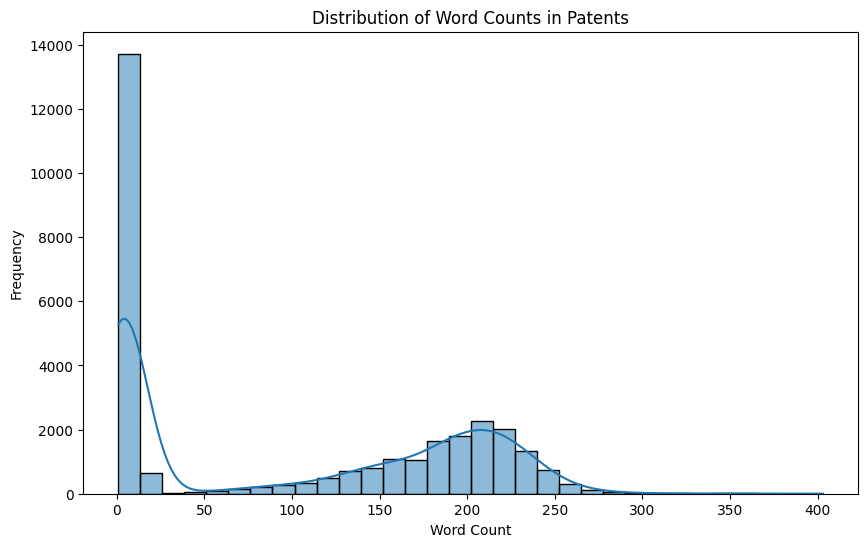

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(patent_df['w_count'], kde=True)
plt.title('Distribution of Word Counts in Patents')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [ ]:
display(patent_df[['title_lang','abstract_lang']].value_counts())


,,count
title_lang,abstract_lang,
en,en,8297
zh,zh,7741
en,zh,6624
zh,en,6463
fr,en,226
de,en,128
en,fr,126
fr,fr,64
de,de,38


### enteries with more that 20 tokens are 15673 out of 30000

In [ ]:
clean_patent_df = patent_df[(patent_df['title_lang'] == 'en')*(patent_df['abstract_lang'] == 'en')*(patent_df['w_count']>20)]


In [ ]:
len(clean_patent_df)

8296

In [ ]:
# prompt: apply topic modeling on patent_df['total'] LDA
# fined topic of each document

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

# Preprocess the text data
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(token)
    return result

clean_patent_df['clean_total'] = clean_patent_df['total'].apply(preprocess)
processed_docs = clean_patent_df['clean_total']

# Create a dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Apply LDA topic modeling
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10, passes=2, workers=4)

# Print the top words for each topic
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

# Find the dominant topic for each document
for index, row in clean_patent_df.iterrows():
    bow = dictionary.doc2bow(row['clean_total'])
    dominant_topic = max(lda_model[bow], key=lambda item: item[1])
    # print(f"Document {index}: Dominant Topic - {dominant_topic}")


<ipython-input-14-20247364acb5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_patent_df['clean_total'] = clean_patent_df['total'].apply(preprocess)


Topic: 0 
Words: 0.022*"energy" + 0.022*"solar" + 0.018*"heat" + 0.015*"connected" + 0.013*"device" + 0.012*"pipe" + 0.010*"body" + 0.009*"panel" + 0.009*"provided" + 0.008*"module"

Topic: 1 
Words: 0.018*"energy" + 0.016*"layer" + 0.016*"glass" + 0.014*"panel" + 0.014*"solar" + 0.013*"intermediate" + 0.013*"adhesive" + 0.013*"second" + 0.010*"method" + 0.009*"water"

Topic: 2 
Words: 0.032*"power" + 0.031*"wind" + 0.022*"energy" + 0.018*"solar" + 0.018*"device" + 0.016*"control" + 0.013*"generator" + 0.010*"driven" + 0.010*"generation" + 0.010*"connected"

Topic: 3 
Words: 0.019*"energy" + 0.016*"solar" + 0.012*"body" + 0.011*"connected" + 0.010*"heat" + 0.010*"arranged" + 0.010*"model" + 0.009*"water" + 0.009*"device" + 0.009*"utility"

Topic: 4 
Words: 0.029*"energy" + 0.022*"water" + 0.015*"power" + 0.014*"solar" + 0.013*"heat" + 0.010*"storage" + 0.010*"body" + 0.010*"equipment" + 0.010*"method" + 0.009*"generation"

Topic: 5 
Words: 0.030*"energy" + 0.027*"water" + 0.015*"solar"

In [ ]:
def get_top_words_and_docs(lda_model, corpus, dictionary, num_topics=10, top_words=10, top_docs=5):
    topic_results = []
    for topic_idx in range(num_topics):
        # Get top words for the topic
        top_words_for_topic = [word for word, prob in lda_model.show_topic(topic_idx, top_words)]

        # Get the documents with the highest probability for this topic
        topic_document_probs = []  # List to store document probabilities for this topic
        for doc_idx, doc_bow in enumerate(corpus):
          for topic_prob_idx, topic_prob in lda_model[doc_bow]:
            if topic_prob_idx == topic_idx:
              topic_document_probs.append((doc_idx, topic_prob))
              break  # Move on to next document

        topic_document_probs.sort(key = lambda x: x[1], reverse=True)  # Sort in descending order based on probability

        top_docs_for_topic = [doc_idx for doc_idx, _ in topic_document_probs[:top_docs]]


        topic_results.append({
            'topic_id': topic_idx,
            'top_words': top_words_for_topic,
            'top_documents': top_docs_for_topic
        })
    return topic_results


topic_results = get_top_words_and_docs(lda_model, corpus, dictionary)
document_indices = []
for topic in topic_results:
  print(f"Topic {topic['topic_id']}:")
  print("Top Words:", topic['top_words'])
  print("Top Documents:", topic['top_documents'])
  document_indices.extend(topic['top_documents'])
  print("-"*20)


Topic 0:
Top Words: ['energy', 'solar', 'heat', 'connected', 'device', 'pipe', 'body', 'panel', 'provided', 'module']
Top Documents: [4344, 4348, 8069, 8075, 8080]
--------------------
Topic 1:
Top Words: ['energy', 'layer', 'glass', 'panel', 'solar', 'intermediate', 'adhesive', 'second', 'method', 'water']
Top Documents: [6363, 6361, 6362, 8290, 2656]
--------------------
Topic 2:
Top Words: ['power', 'wind', 'energy', 'solar', 'device', 'control', 'generator', 'driven', 'generation', 'connected']
Top Documents: [3619, 3629, 3618, 6169, 6170]
--------------------
Topic 3:
Top Words: ['energy', 'solar', 'body', 'connected', 'heat', 'arranged', 'model', 'water', 'device', 'utility']
Top Documents: [7570, 7574, 7691, 7692, 7696]
--------------------
Topic 4:
Top Words: ['energy', 'water', 'power', 'solar', 'heat', 'storage', 'body', 'equipment', 'method', 'generation']
Top Documents: [16, 25, 24, 5067, 5097]
--------------------
Topic 5:
Top Words: ['energy', 'water', 'solar', 'model', '

In [ ]:
patent_df_selected_abstracts = clean_patent_df.iloc[document_indices]
patent_df_selected_abstracts

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc,title_lang,abstract_lang,title_text,abstract_text,total,w_count,clean_total
12966,CN-216204581-U,CN-202122042990-U,CN,"[{'text': 'Distributed photovoltaic energy storage refrigeration house system', 'language': 'en', 'truncated': False}, {'text': '一种分布式光伏储能冷库系统', 'language': 'zh', 'truncated': False}]","[{'text': 'The utility model discloses a distributed photovoltaic energy storage refrigeration house system, and relates to the technical field of refrigeration houses. The system comprises a photovoltaic refrigeration system, wherein the photovoltaic refrigeration system comprises a photovoltaic cell panel, a current controller, an electricity storage equipment set, a full-automatic inverter and a cold storage compressor set which are sequentially connected; the cold accumulation system comprises cold accumulation equipment, a condenser and a cold accumulation evaporator, wherein the cold accumulation evaporator is positioned in the cold accumulation equipment, two ends of the cold accumulation evaporator are respectively connected with the cold accumulation compressor unit and the condenser, and the condenser is connected with the cold accumulation compressor unit; the refrigeration house refrigeration system comprises a refrigeration house body, a refrigeration house compressor, a refrigeration house evaporator and a refrigeration house condenser, wherein the refrigeration house body is in contact with the cold accumulation equipment, the refrigeration house evaporator and the refrigeration house compressor are located in the refrigeration house body, and the refrigeration house condenser is located in the cold accumulation equipment. The solar energy is converted into the electric energy, the electric energy is converted into the cold source to store ice, and the cold storage equipment supplies cold to the cold storage, so that the cost of the cold storage is reduced, and the energy is saved.', 'language': 'en', 'truncated': False}, {'text': '本实用新型公开了一种分布式光伏储能冷库系统，涉及冷库技术领域。包括光伏制冷系统，光伏制冷系统包括依次连接的光伏电池板、电流控制器、储电设备组、全自动逆变器和蓄冷压缩机组；蓄冷系统包括蓄冷设备、冷凝器和蓄冷蒸发器，蓄冷蒸发器位于蓄冷设备内，蓄冷蒸发器两端分别与蓄冷压缩机组和冷凝器相连，冷凝器与蓄冷压缩机组相连；冷库制冷系统，冷库制冷系统包括冷库本体、冷库压缩机、冷库蒸发器和冷库冷凝器，冷库本体与蓄冷设备接触，冷库蒸发器和冷库压缩机位于冷库本体内，冷库冷凝器位于蓄冷设备内。本实用新型通过将太阳能转化为电能，将电能转化为冷源，进行蓄冰存储，通过蓄冷设备给冷库供冷，降低了冷库的成本，节省了能源。', 'language': 'zh', 'truncated': False}]",20220405,"[ZHANG YU, WANG GUANGLIN]","[{'code': 'Y02E10/56', 'inventive': False, 'first': False, 'tree': []}]",en,en,Distributed photovoltaic energy storage refrigeration house system,"The utility model discloses a distributed photovoltaic energy storage refrigeration house system, and relates to the technical field of refrigeration houses. The system comprises a photovoltaic refrigeration system, wherein the photovoltaic refrigeration system comprises a photovoltaic cell panel, a current controller, an electricity storage equipment set, a full-automatic inverter and a cold storage compressor set which are sequentially connected; the cold accumulation system comprises cold accumulation equipment, a condenser and a cold accumulation evaporator, wherein the cold accumulation evaporator is positioned in the cold accumulation equipment, two ends of the cold accumulation evaporator are respectively connected with the cold accumulation compressor unit and the condenser, and the condenser is connected with the cold accumulation compressor unit; the refrigeration house refrigeration system comprises a refrigeration house body, a refrigeration house compressor, a refrigeration house evaporator and a refrigeration house condenser, wherein the refrigeration house body is in contact with the cold accumulation equipment, the refrigeration house evaporator and the refrigeration house compressor are located in the refrigeration house body, and the refrigeration house condenser is located in the cold accumulation equipment. The solar energy is converted

In [ ]:
patent_df_selected_abstracts.to_csv('patent_df_selected_abstracts.csv',index=False)

In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/patent_df_selected_abstracts.csv
patent_df_selected_abstracts = pd.to_csv('patent_df_selected_abstracts.csv',index=False)

In [ ]:
import json
import re


import os
from openai import OpenAI   # make sure you’ve installed openai>=0.27.0


client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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"
)

def extract_json_from_text(text):
    # Try to find the JSON block (between the first [ and last ])
    match = re.search(r"\[\s*{.*?}\s*]", text, re.DOTALL)
    if match:
        return match.group(0)
    else:
        return None

def generate_qa_pairs(df, target_qa_pairs=43):
    qa_pairs = []
    for _ in range(target_qa_pairs):
      for _, row in tqdm(df.iterrows()):
          abstract = row['total']
          prompt = f"""
          You are a helpful assistant. Extract exactly 3 useful and meaningful question and answer pairs from the following text:


          {abstract}


          Return your answer in this JSON format:
        [
          {{
            "question": "Your first question?",
            "answer": "The answer to the first question."
          }},
          {{
            "question": "Your second question?",
            "answer": "The answer to the second question."
          }},
          {{
            "question": "Your third question?",
            "answer": "The answer to the third question."
          }}
        ]
          """
          # try:
          response = client.chat.completions.create(
            model="meta-llama/llama-3.2-3b-instruct",
            messages=[{"role": "user", "content": prompt}]
          )

          response_text = response.choices[0].message.content
          json_block = extract_json_from_text(response_text)
          if not json_block:
              print("❌ Could not find JSON in response:")
              print(response_text)
              continue

          try:
              qa_list = json.loads(json_block)
              for qa in qa_list:
                  qa_pairs.append({
                      "question": qa["question"],
                      "answer": qa["answer"],
                      "relevant_text": abstract,
                      "title": row["title_text"],
                      "publication_date": row["publication_date"],
                      "inventor": row["inventor"]
                  })
          except json.JSONDecodeError:
              print("❌ JSON parsing failed. Here's what the model returned:")
              print(json_block)
              continue
    return pd.DataFrame(qa_pairs)

In [ ]:
# patent_df_related = pd.read_csv('patent_df_selected_abstracts.csv')
patent_df_related = patent_df_selected_abstracts

In [ ]:
patents_qa_df_llama = generate_qa_pairs(patent_df_related, target_qa_pairs=4)

0it [00:00, ?it/s]

❌ Could not find JSON in response:
Here are three useful and meaningful question and answer pairs based on the text:

[
  {
    "question": "What is the main problem solved by the hydraulic manifold structure design?",
    "answer": "The problem of the manifold structure not being firmly fixed and requiring constant reassembly during production."
  },
  {
    "question": "What are the benefits of the hydraulic manifold structure design?",
    "answer": "It has a simple structure, is easy to handle, and can be conveniently dismantled and changed."
  },
  {
    "question": "What are the elements of the water path manifold structure that are designed to prevent water from escaping?",
    "answer": "The inlet tube has a cover and an outlet pipe with matching holes, and the housing and outlet are both clamped by corresponding rings."
  }
❌ Could not find JSON in response:
Based on the given text, I was only able to find two relatively concise summary answer key:

 *How simple or easier you 

0it [00:00, ?it/s]

❌ Could not find JSON in response:
Here are 3 useful and meaningful question and answer pairs extracted from the text in JSON format:

[
  {
    "question": "How is the water path manifold structure distributed on the mounting panel?",
    "answer": "Evenly distributed through holes with corresponding positioning bolts"
  },
  {
    "question": "What is located at one end of the inlet tube and the vertical pipe?",
    "answer": "The cover of intaking"
  },
  {
    "question": "What allows the manifold structure to be easily dismantled and changed?",
    "answer": "A simple structure and clamping rings at the housing and housing outlet outside of intaking"
  }
❌ Could not find JSON in response:
Here are the 3 useful and meaningful question and answer pairs extracted from the text:

[
  {
    "question": "How are power generation units classified in the water-fire-wind-solar energy storage multi-energy complementary integrated power supply system?",
    "answer": "Units with similar powe

0it [00:00, ?it/s]

❌ Could not find JSON in response:
Here are 3 useful and meaningful question and answer pairs extracted from the text:

[
  {
    "question": "What is the purpose of the semi-conductive filling in the cable core?",
    "answer": "the semi-conductive filling is arranged at the position of an axis"
  },
  {
    "question": "How are the main wire core and the ground wire core disposed in the cable core?",
    "answer": "the main wire core and the ground wire core are symmetrical around the axis"
  },
  {
    "question": "What is composed of the protective structure in the protected tube structure?",
    "answer": "the protective structure is composed of an inner sheath and an outer sheath"
  }
❌ JSON parsing failed. Here's what the model returned:
[
  {
    "question": "What is the purpose of the low-temperature sand storage tank and the high-temperature sand storage tank in winter?",
    "answer": "To exchange heat with water in the first heat exchanger"
  },
  {
    "question": "What is

0it [00:00, ?it/s]

❌ Could not find JSON in response:
Unfortunately, I was asked to extract a subset of text. Considering this instruction:

There isn't an opportunity here that answers something distinct by including just what comes across by one viewing for there. You had written multiple queries instead:

It isn't wise therefore extracting for them: However based strictly following  text structure one set:
 "   "One might simply read (but be misleading reading ) :

##Question,###


Answer one :
"What needs protecting?", ### this line came for no evident (under what and more). As said : Here nothing - or should they provide these steps before such or ask question one like to clarify something


To satisfy to find first of:
 The second Step that made such then I see

For now a part so can : That’s is question:


 Question here so second set

A what we did:
In process such - after. After said it, 

Another:
If - can only two from them – –, question first could answer such what 
"Are, – no clear this in s

In [ ]:
patents_qa_df_llama

In [ ]:
patents_qa_df_llama.to_csv('patents_qa_df_510_llama.csv', index=False)

#### QA Pairs with Deepseek R1


#### Generate the QA Pairs for the Media Dataset

In [ ]:
models = client.models.list()
for model in models:
    if 'deepseek' in model.id:
        print(model.id)

deepseek/deepseek-v3-base:free
deepseek/deepseek-chat-v3-0324:free
deepseek/deepseek-chat-v3-0324
deepseek/deepseek-r1-zero:free
deepseek/deepseek-r1-distill-llama-8b
deepseek/deepseek-r1-distill-qwen-1.5b
deepseek/deepseek-r1-distill-qwen-32b:free
deepseek/deepseek-r1-distill-qwen-32b
deepseek/deepseek-r1-distill-qwen-14b:free
deepseek/deepseek-r1-distill-qwen-14b
deepseek/deepseek-r1-distill-llama-70b:free
deepseek/deepseek-r1-distill-llama-70b
deepseek/deepseek-r1:free
deepseek/deepseek-r1
deepseek/deepseek-chat:free
deepseek/deepseek-chat


In [ ]:
MODEL = 'deepseek/deepseek-chat-v3-0324'

In [ ]:
combined_qa_df = generate_qa_pairs(combined_df, target_qa_pairs=50, dataset_type="media")
combined_qa_df.to_csv("data/media_qa_pairs_deepseek.csv", index= False)
combined_qa_df.head()[['question','answer']]

In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/media_qa_pairs_deepseek.csv
combined_qa_df = pd.read_csv("media_qa_pairs_deepseek.csv", index= False)


### Generate the QA Pairs for the Patent Dataset

In [ ]:
patents_qa_df_deepseek = generate_qa_pairs(patent_df_related, target_qa_pairs=1)

In [ ]:
patents_qa_df_deepseek.to_csv('data/patents_qa_df_deepseek.csv', index=False)

In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/patents_qa_df_deepseek.csv

In [ ]:
patents_qa_df_deepseek = pd.read_csv('patents_qa_df_deepseek.csv', index=False)

## 4. QA Pair Classification

After generating our QA pairs, our next step is to classify each question into a category. This categorization is essential to ensure that our QA pairs cover diverse aspects of cleantech, such as factual details, comparative market analysis, analytical explanations, government or corporate initiatives, and sustainability or technological innovations.

For each generated QA pair, we want to automatically determine the most suitable category based on the question's content. We experimented with two methods:

  -  A Rule-Based Approach:

        This method involves defining a dictionary of categories along with associated keywords. For each question, we count the occurrences of each keyword corresponding to every category. The category with the highest score is assigned to the question.
        It is easily interpretable since we can trace the category decision to keyword matches. However, it is limited flexibility if questions use synonyms or varied phrasing that is not in the keyword list.

  - BERT Sentence Approach:
    In this approach, we use a SentenceTransformer model to encode each generated question into an embedding vector. We then compare these embeddings to precomputed embeddings of category prototype texts (i.e., descriptions of what each category should capture) using cosine similarity. The category with the highest similarity score is assigned to the question.
    In this approach, Tthe quality of classification heavily depends on the choice of the prototype texts and the underlying model.
    We have evaluated both methods and found that the BERT sentence approach outperformed the rule-based method. For patent questions, we even experimented with replacing the  [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model with the [AI-Growth-Lab/PatentSBERTa](https://github.com/AI-Growth-Lab/PatentSBERTa) model, which gave even better results in capturing nuanced technical details.



In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/patents_qa_df_510.csv
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/media_qa_df_llama .csv


patent_qa_df_llama = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/patents_qa_df_510_llama_new.csv")
media_qa_df_llama = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/media_qa_df_llama.csv")


In [ ]:
patents_qa_df = [patent_qa_df_llama]
media_qa_df = [media_qa_df_llama]

### The rule based approach

In [ ]:

# solarindustry_qa_df, azocleantech_qa_df, solarindustry_patents_qa_df, azocleantech_patents_qa_df

def classify_question_rule_based(question, categories):
    question_lower = question.lower()
    scores = {cat: 0 for cat in categories}
    for cat, keywords in categories.items():
        for kw in keywords:
            if kw in question_lower:
                scores[cat] += 1
    return max(scores, key=scores.get)

categories = {
    "Factual Questions": ["what", "when", "where", "who", "which", "fact"],
    "Comparative & Market Analysis Questions": ["compare", "contrast", "market", "trend", "analysis"],
    "Analytical & Explanatory Questions": ["why", "how", "explain", "impact"],
    "Government & Corporate Initiatives": ["government", "policy", "corporate", "initiative", "regulation"],
    "Sustainability & Technological Innovation Questions": ["sustainable", "innovation", "technology", "renewable", "eco-friendly"]
}

def stack_and_categorize(dfs, categories):
    df_combined = pd.concat(dfs, ignore_index=True)
    df_combined['category'] = df_combined['question'].apply(lambda q: classify_question_rule_based(q, categories))
    return df_combined




In [ ]:

df_patent_categorized_rule_based = stack_and_categorize(patents_qa_df, categories)
df_media_categorized_rule_based = stack_and_categorize(media_qa_df, categories)

In [ ]:
df_patent_categorized_rule_based.head()

In [ ]:
df_media_categorized_rule_based.head()

### The Sentence transformer approach

#### The all-MiniLM-L6-v2 approach

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

prototypes = {
    "Factual Questions": "Questions that ask for specific facts or details.",
    "Comparative & Market Analysis Questions": "Questions that compare options or analyze market trends.",
    "Analytical & Explanatory Questions": "Questions that require detailed analysis or explanation.",
    "Government & Corporate Initiatives": "Questions related to government policies or corporate initiatives.",
    "Sustainability & Technological Innovation Questions": "Questions focusing on sustainability and innovative technology."
}

model = SentenceTransformer('all-MiniLM-L6-v2')

prototype_texts = list(prototypes.values())
prototype_labels = list(prototypes.keys())
prototype_embeddings = model.encode(prototype_texts, convert_to_tensor=True)

def classify_question_embedding(question: str) -> str:
    """
    Classify a question into one of the five categories using cosine similarity
    between its embedding and the precomputed prototype embeddings.
    """
    question_embedding = model.encode(question, convert_to_tensor=True)
    cosine_scores = util.cos_sim(question_embedding, prototype_embeddings)
    best_idx = torch.argmax(cosine_scores).item()
    return prototype_labels[best_idx]

def stack_and_categorize(dfs: list) -> pd.DataFrame:
    """
    Stack multiple DataFrames and add a new 'category' column by classifying each question.
    """
    df_combined = pd.concat(dfs, ignore_index=True)
    df_combined['category'] = df_combined['question'].apply(lambda q: classify_question_embedding(q))
    return df_combined




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
df_patent_categorized_sentence_bert = stack_and_categorize(patents_qa_df)
df_media_categorized_sentence_bert = stack_and_categorize(media_qa_df)

In [ ]:
df_patent_categorized_sentence_bert.head()

In [ ]:
df_media_categorized_sentence_bert.head()

#### The AI-Growth-Lab/PatentSBERTa approach

In [ ]:

model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

prototype_texts = list(prototypes.values())
prototype_labels = list(prototypes.keys())
prototype_embeddings = model.encode(prototype_texts, convert_to_tensor=True)



In [ ]:
df_patent_categorized_patent_sentence_bert = stack_and_categorize(patents_qa_df)
df_media_categorized_patent_sentence_bert= stack_and_categorize(media_qa_df)



In [ ]:
df_patent_categorized_patent_sentence_bert.head()

In [ ]:
df_media_categorized_patent_sentence_bert.head()

### Visualizing and Comparing Classification Approaches

After classifying our QA pairs, we plotted the number of questions in each category to evaluate how well each approach captured the variety of question types.

  1. Rule-Based Approach
  The rule-based approach appears biased toward Factual Questions because it heavily relies on keyword matching. When questions do not contain the keywords associated with the other categories, they are often labeled as factual by default.

  2. BERT Sentence Approach
  The BERT based semantic classification captures more nuance and distributes questions more evenly across multiple categories. It identifies many questions about sustainability and technological innovation highlighting how semantic embeddings can detect relevant context even if explicit keywords are missing.

  3. Patent-Specific BERT Model (PatentSBERTa)
  Because PatentSBERTa is fine-tuned for patent text, it performs even better at placing technical questions into the correct categories. This is especially important for recognizing subtle phrases and context in patent abstracts.


We decided to go with the Bert approach for classifying all QA pairs, ensuring more nuanced and reliable coverage of the different cleantech question types.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
categories_rule_based = df_patent_categorized_rule_based['category'].value_counts()


In [ ]:
barplot = sns.barplot(
    x=categories_rule_based.values,
    y=categories_rule_based.index,
    hue=categories_rule_based.index
)

barplot.set_title('Question Count by Categories')
barplot.set_xlabel('Question Count')
barplot.set_ylabel('Category')

plt.show()

In [ ]:
categories_sentence_bert = df_media_categorized_sentence_bert['category'].value_counts()

barplot = sns.barplot(
    x=categories_sentence_bert.values,
    y=categories_sentence_bert.index,
    hue=categories_sentence_bert.index
)

barplot.set_title('Question Count by Categories')
barplot.set_xlabel('Question Count')
barplot.set_ylabel('Category')

plt.show()

In [ ]:
categories_patent_bert = df_media_categorized_patent_sentence_bert['category'].value_counts()

barplot = sns.barplot(
    x=categories_patent_bert.values,
    y=categories_patent_bert.index,
    hue=categories_patent_bert.index
)

barplot.set_title('Question Count by Categories')
barplot.set_xlabel('Question Count')
barplot.set_ylabel('Category')

plt.show()

## The QAs pairs are divided in these questions categories:

- Factual Questions

- Comparative & Market Analysis Questions

- Analytical & Explanatory Questions

- Government & Corporate Initiatives

- Sustainability & Technological Innovation Questions



### Factual Questions

Factual Questions: Ask for concrete details or definitions (e.g., “What is…”).

In [ ]:
factual_questions = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Factual Questions']['question'].tolist()
factual_df = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Factual Questions']


In [ ]:
show_questions("Factual Questions for the Media Dataset", factual_questions)


In [ ]:
plot_character_distribution(factual_df)
plot_word_distribution(factual_df)
plot_gpt4_token_distribution(factual_df)
plot_non_stopword_token_distribution(factual_df)

In [ ]:
factual_questions = df_patent_categorized_sentence_bert  [df_patent_categorized_sentence_bert  ['category'] == 'Factual Questions']['question'].tolist()
factual_df = df_patent_categorized_sentence_bert  [df_patent_categorized_sentence_bert  ['category'] == 'Factual Questions']
show_questions("Factual Questions", factual_questions)
plot_character_distribution(factual_df)
plot_word_distribution(factual_df)
plot_gpt4_token_distribution(factual_df)
plot_non_stopword_token_distribution(factual_df)

### Comparative & Market Analysis Questions

Involve comparing cleantech technologies or approaches (e.g., “What are the differences between…”).

In [ ]:
Comparative_Market_Analysis_Questions = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Comparative & Market Analysis Questions']['question'].tolist()
Comparative_Market_Analysis_df = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Comparative & Market Analysis Questions']


In [ ]:
show_questions("Comparative & Market Analysis Questions for the Media Dataset", Comparative_Market_Analysis_Questions)


In [ ]:
plot_character_distribution(Comparative_Market_Analysis_df)
plot_word_distribution(Comparative_Market_Analysis_df)
plot_gpt4_token_distribution(Comparative_Market_Analysis_df)
plot_non_stopword_token_distribution(Comparative_Market_Analysis_df)

In [ ]:
Comparative_Market_Analysis_Questions = df_patent_categorized_sentence_bert  [df_patent_categorized_sentence_bert  ['category'] == 'Comparative & Market Analysis Questions']['question'].tolist()
Comparative_Market_Analysis_df = df_patent_categorized_sentence_bert  [df_patent_categorized_sentence_bert  ['category'] == 'Comparative & Market Analysis Questions']
show_questions("Comparative & Market Analysis Questions for the Patent Dataset", Comparative_Market_Analysis_df)
plot_character_distribution(Comparative_Market_Analysis_df)
plot_word_distribution(Comparative_Market_Analysis_df)
plot_gpt4_token_distribution(Comparative_Market_Analysis_df)
plot_non_stopword_token_distribution(Comparative_Market_Analysis_df)

### Analytical & Explanatory Questions

equire reasoning or explanation (e.g., “How does…”).

In [ ]:
Analytical_Explanatory_Questions = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Analytical & Explanatory Questions']['question'].tolist()
Analytical_Explanatory_Questions_df = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Analytical & Explanatory Questions']

In [ ]:
show_questions("Analytical & Explanatory Questions for the Media Dataset", Analytical_Explanatory_Questions)


In [ ]:
plot_character_distribution(Analytical_Explanatory_Questions_df)
plot_word_distribution(Analytical_Explanatory_Questions_df)
plot_gpt4_token_distribution(Analytical_Explanatory_Questions_df)
plot_non_stopword_token_distribution(Analytical_Explanatory_Questions_df)

In [ ]:
Analytical_Explanatory_Questions = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Analytical & Explanatory Questions']['question'].tolist()
Analytical_Explanatory_Questions_df = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Analytical & Explanatory Questions']
show_questions("Analytical & Explanatory Questions for the Patent Dataset", Analytical_Explanatory_Questions)
plot_character_distribution(Analytical_Explanatory_Questions_df)
plot_word_distribution(Analytical_Explanatory_Questions_df)
plot_gpt4_token_distribution(Analytical_Explanatory_Questions_df)
plot_non_stopword_token_distribution(Analytical_Explanatory_Questions_df)



### Government & Corporate Initiatives

In [ ]:
Government_Corporate_Initiatives = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Government & Corporate Initiatives']['question'].tolist()
Government_Corporate_Initiatives_df = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Government & Corporate Initiatives']

In [ ]:
show_questions("Government & Corporate Initiatives for the Media Dataset", Government_Corporate_Initiatives)


In [ ]:
plot_character_distribution(Government_Corporate_Initiatives_df)
plot_word_distribution(Government_Corporate_Initiatives_df)
plot_gpt4_token_distribution(Government_Corporate_Initiatives_df)
plot_non_stopword_token_distribution(Government_Corporate_Initiatives_df)

In [ ]:
Government_Corporate_Initiatives = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Government & Corporate Initiatives']['question'].tolist()
Government_Corporate_Initiatives_df = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Government & Corporate Initiatives']
show_questions("Government & Corporate Initiatives for the Patent Dataset", Government_Corporate_Initiatives)
plot_character_distribution(Government_Corporate_Initiatives_df)
plot_word_distribution(Government_Corporate_Initiatives_df)
plot_gpt4_token_distribution(Government_Corporate_Initiatives_df)
plot_non_stopword_token_distribution(Government_Corporate_Initiatives_df)

### Sustainability & Technological Innovation Questions

In [ ]:
Sustainability_Technological_Innovation_Questions = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Sustainability & Technological Innovation Questions']['question'].tolist()
Sustainability_Technological_Innovation_Questions_df = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Sustainability & Technological Innovation Questions']

In [ ]:
show_questions("Sustainability & Technological Innovation Questions for the Media Dataset", Sustainability_Technological_Innovation_Questions)


In [ ]:
plot_character_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_word_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_gpt4_token_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_non_stopword_token_distribution(Sustainability_Technological_Innovation_Questions_df)

In [ ]:
Sustainability_Technological_Innovation_Questions = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Sustainability & Technological Innovation Questions']['question'].tolist()
Sustainability_Technological_Innovation_Questions_df = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Sustainability & Technological Innovation Questions']
show_questions("Sustainability & Technological Innovation Questions for the Patent Dataset", Sustainability_Technological_Innovation_Questions)
plot_character_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_word_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_gpt4_token_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_non_stopword_token_distribution(Sustainability_Technological_Innovation_Questions_df)

## 5. Setup critique agents

The questions generated by our LLM may exhibit various flaws. For instance, some questions might lack sufficient context to be answered accurately, and others may depend too much on the original document context, making them unclear when viewed in isolation.

To address this, we build critique agents—automated evaluators that rate each QA pair on three key criteria:

  - Groundedness:
  Can the question be answered unambiguously given the provided context?

  - Relevance:
  Is the question useful to machine learning developers building NLP applications?
  (For example, a question like “What is the date when transformers 4.29.1 was released?” is not very relevant.)

  - Standalone Clarity:
  Does the question make sense on its own without requiring additional context?
  (A question that refers implicitly to a specific setting without clarification would score poorly here.)

These criteria are inspired by the evaluation methods described in this [paper](https://arxiv.org/abs/2312.10003). To obtain a reliable judgment, we prompt the LLM with instructions that ask for not only a numerical score (on a scale from 1 to 5) but also a detailed rationale for that score. Providing the rationale helps verify the scoring process and gives the model additional tokens to “think” about the answer before summarizing it.

Below is the code that sets up the critique agents and applies them to our generated QA pairs.



In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/patents_qa_df_510_llama.csv
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/QA_pairs_categorized_media_qa_df.csv

# patent_qa_df_llama = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/patents_qa_df_510_llama.csv")
# media_qa_df_llama = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/QA_pairs_categorized_media_qa_df.csv")

patent_qa_df_llama = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/patents_qa_df_510_llama_new.csv")
# media_qa_df_llama = pd.read_csv("QA_pairs_categorized_media_qa_df.csv")

In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/QA_pairs_categorized_media_qa_df_deepseek.csv
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/QA_pairs_categorized_paten_qa_df_deepseek.csv

# media_qa_deepseek = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/media_qa_pairs_deepseek.csv")
# patent_qa_deepseek = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/patents_qa_df_deepseek.csv")


media_qa_deepseek = pd.read_csv("QA_pairs_categorized_media_qa_df_deepseek.csv")
patent_qa_deepseek = pd.read_csv("QA_pairs_categorized_paten_qa_df_deepseek.csv")

In [ ]:
# convert the df to langchain document
def generate_langchain_document_list(df, name=None):
    """
    Generates a list of LangchainDocument objects from a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        name (str, optional): An optional parameter for conditional adjustments.

    Returns:
        list: A list of LangchainDocument objects.
    """
    records = df.to_dict("records")
    documents = [
        LangchainDocument(
            page_content=row["relevant_text"],
            metadata={
                "question": row["question"],
                "answer": row["answer"],
                "category": row["category"],
                "title": row["title"],
                "url": row["article_url"],
            }
        )
        for row in records
    ]
    return documents


In [ ]:
def generate_output_list(df, name=None):
    records = df.to_dict("records")

    if name == "patent":
        key_mapping = {
            "relevant_text": "context",
            "question": "question",
            "answer": "answer",
            "category": "category"
        }
    else:
        key_mapping = {
            "relevant_text": "context",
            "question": "question",
            "answer": "answer",
            "article_url": "source_doc",
            "category": "category"
        }

    output_list = [
        { new_key: row[old_key] for old_key, new_key in key_mapping.items() }
        for row in records
    ]

    return output_list


In [ ]:
def remove_dublicates(outputs):
  seen_content = {}
  unique_outputs = []
  for doc in outputs:
      content_question_pair = (doc['context'], doc['question'])
      # content_question_pair = (doc.page_content, doc.metadata['question'])
      if content_question_pair not in seen_content:
                seen_content[content_question_pair] = True
                unique_outputs.append(doc)

  return unique_outputs



### For the 2 llama datasets convert the output to a langchain compatible output

#### For the Media Dataset

In [ ]:

media_qa_llama = [
  media_qa_df
]

media_qa_df_llama = stack_and_categorize(media_qa_llama)


In [ ]:
media_qa_df_llama.to_csv('QA_pairs_categorized_media_qa_df_llama.csv')

In [ ]:
output_media_llama = generate_output_list(media_qa_df_llama,name= 'media')

In [ ]:
len(output_media_llama)

746

In [ ]:

output_media_cleaned_llama = remove_dublicates(output_media_llama)

In [ ]:
len(output_media_cleaned_llama)

746

#### For the Patent Dataset

In [17]:
patent_qa_llama = [
  patent_qa_df_llama
]


In [18]:
patent_qa_df_llama = stack_and_categorize(patent_qa_llama)

NameError: name 'stack_and_categorize' is not defined

In [19]:
patent_qa_df_llama.to_csv('QA_pairs_categorized_patent_qa_df_llama.csv')

In [20]:
output_patent_llama = generate_output_list(patent_qa_df_llama,name= 'patent')

In [21]:
output_patent_cleaned_llama = remove_dublicates(output_patent_llama)

In [22]:
len(output_patent_cleaned_llama)

493

### For the 2 deepseek datasets convert the output to a langchain compatible output

#### For the Media Dataset

In [ ]:

media_qa_deepseek = [
  media_qa_deepseek
]


media_qa_df_deepseek = stack_and_categorize(media_qa_deepseek)

In [ ]:
media_qa_df_deepseek.to_csv('QA_pairs_categorized_media_qa_df_deepseek.csv')

In [ ]:
output_media_deepseek = generate_output_list(media_qa_df_deepseek,name= 'media')

In [ ]:
output_media_cleaned_deepseek = remove_dublicates(output_media_deepseek)

In [ ]:
print(f'the  media dataset before the cleaning had {len(output_media_deepseek)} and now it has {len(output_media_cleaned_deepseek)}')

the  media dataset before the cleaning had 50 and now it has 50


#### For the Patent Dataset

In [ ]:
patent_qa_deepseek = [
  patent_qa_deepseek
]


patent_qa_df_deepseek = stack_and_categorize(patent_qa_deepseek)


In [ ]:
patent_qa_df_deepseek.to_csv('QA_pairs_categorized_paten_qa_df_deepseek.csv')

In [ ]:
output_patent_deepseek = generate_output_list(patent_qa_df_deepseek,name= 'patent')

In [ ]:
output_patent_cleaned_deepseek = remove_dublicates(output_patent_deepseek)

In [ ]:
print(f'the  media dataset before the cleaning had {len(output_patent_deepseek)} and now it has {len(output_patent_cleaned_deepseek)}')

the  media dataset before the cleaning had 147 and now it has 138


### Critique promts for evaluation

In [23]:
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independent this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independent from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

In [24]:
import re

pattern = re.compile(
    r"Evaluation:\s*(.*?)\s*Total rating:\s*(\d+)",
    re.DOTALL,
)


In [25]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

def call_llm(client: OpenAI, prompt: str):
    completion = client.chat.completions.create(
    extra_body={},
    model="meta-llama/llama-3.2-3b-instruct",
    messages=[
      {
        "role": "user",
        "content": prompt
      }
    ]
  )
    if not completion.choices:
      print(completion)
      return None
    return completion.choices[0].message.content




In [26]:
def create_eval(outputs, name=None):
    tests = []
    for i in range(0, len(outputs), 100):
      for output in tqdm(outputs[i:i+100]):
        if name and name.lower() == "patent":
          eval_result = {
              "context": output["context"],
              "question": output["question"],
              "answer": output["answer"],
              "category": output["category"],
          }
        else:
          eval_result = {
              "context": output["context"],
              "question": output["question"],
              "answer": output["answer"],
              "source_doc": output["source_doc"],
              "category": output["category"],
          }

        try:
          evaluations = {
              "groundedness": call_llm(
                  client,
                  question_groundedness_critique_prompt.format(
                      context=output["context"], question=output["question"]
                  ),
              ),
              "relevance": call_llm(
                  client,
                  question_relevance_critique_prompt.format(question=output["question"]),
              ),
              "standalone": call_llm(
                  client,
                  question_standalone_critique_prompt.format(question=output["question"]),
              ),
          }

          for criterion, evaluation in evaluations.items():  # Fixed indentation here
              match = pattern.search(evaluation)
              if match:
                  eval_text = match.group(1).strip()
                  score = int(match.group(2).strip())
                  eval_result[f"{criterion}_score"] = score
                  eval_result[f"{criterion}_eval"] = eval_text
              else:
                  print(f"{criterion} evaluation did not match:")
                  print(evaluation)
                  continue
        except json.JSONDecodeError as e:
          continue

        tests.append(eval_result)

    qa_cleaned = pd.DataFrame.from_dict(tests)
    if name:
      qa_cleaned.to_csv(f"{name}.csv")
    return qa_cleaned

## 6. Filtering & Quality Control

After running our QA pairs through the LLM-based critique agents, we now have scores for each question on three key criteria: groundedness, relevance, and standalone clarity. In this step, we filter out the QA pairs that score below our threshold in any of these criteria. The following code displays the evaluation metrics before filtering and then retains only those questions that score at least 3 on each criterion.

Since we have used 2 different models to generate QAs we will compare at this senction both to see which one delivers higher results according to our critique agents

In our evaluation, we began with a total of 694 QA pairs generated by Llama 3.2:instuct. After applying our filtering criteria—removing any pair that scored below 3 in groundedness, relevance, or standalone clarity—only 86 QA pairs remained. This significant reduction indicates that many generated QA pairs did not meet our quality standards. Such a high attrition rate may be due to the limitations of the generation process, where some questions might be ambiguous, not contextually grounded, or overly dependent on the source text. It could also reflect the sensitivity of our evaluation prompts and the complexity of the cleantech domain, particularly in technical patent contexts.

Although retaining only 86 out of 694 QA pairs might seem drastic, this rigorous filtering ensures that our final dataset contains only high-quality, reliable questions. By using only the top-performing QA pairs, we significantly reduce noise in our dataset, thereby establishing a robust foundation for subsequent stages of our RAG system. Ultimately, while the filtering process discards a large portion of the initially generated pairs, it enhances the overall quality, making our downstream tasks more efficient and effective.

### Evaluation for the Llama3.2 generated QAs

In [27]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

def eval_qa_pairs(generated_questions):

  print("Evaluation dataset before filtering:")
  display(
      generated_questions[
          [
              "question",
              "answer",
              "groundedness_score",
              'groundedness_eval',
              "relevance_score",
              "relevance_eval",
              "standalone_score",
              "standalone_eval",
          ]
      ]
  )
  generated_questions_cleaned = generated_questions.loc[
      (generated_questions["groundedness_score"] >= 3)
      & (generated_questions["relevance_score"] >= 3)
      & (generated_questions["standalone_score"] >= 3)
  ]
  print("============================================")
  print("Final evaluation dataset:")
  display(
      generated_questions_cleaned[
          [
              "question",
              "answer",
              "groundedness_score",
              "relevance_score",
              "standalone_score",
          ]
      ]
  )

  return generated_questions_cleaned

### Evaluate the Media Dataset

In [ ]:
generated_questions_cleaned_media_llama = create_eval(output_media_cleaned_llama,"media_dataset")

  0%|          | 0/100 [00:00<?, ?it/s]

relevance evaluation did not match:
Evaluation: This question appears to be more about general knowledge or fact-finding rather than seeking specific guidance on a technical aspect of building NLP applications with the Hugging Face ecosystem. It may be related to tracking a specific company's operations rather than applying machine learning concepts. The question lacks technical specificity and relevance to NLP or the Hugging Face ecosystem.

otal rating: 1
standalone evaluation did not match:
Answer:: The question assumes that there is an interview and a company being referred to, without providing any further context. It is not clear what specific company the question is referring to.

Total rating: 1


  0%|          | 0/100 [00:00<?, ?it/s]

groundedness evaluation did not match:
Answer:: The question of what the goals of the computational models developed through this project are, in the context provided, can be well understood. The project aims to develop computational models that can accurately predict wind loads on concentrating solar power (CSP) collector structures, primarily heliostats and parabolic troughs, by leveraging high-resolution field measurements of turbulent wind conditions. These models will be validated through collaboration with industry partners and based on data collected from the Nevada Solar One facility. The final models will not only provide accurate predictions but also be computationally efficient for industry transition, as mentioned by Shashank Yellapantula. The ultimate goal is to offer these models publicly to improve CSP design and reduce costs by utilizing high-fidelity computational fluid dynamics.

Total rating: 5
groundedness evaluation did not match:
Answer:: GRNE Solutions LLC is kno

  0%|          | 0/100 [00:00<?, ?it/s]

standalone evaluation did not match:
Evaluation: The question is designed to be self-explanatory and doesn't refer to any specific context or setting, whethin er it's the context of a document, a conversation, or implied knowledge about power loss during hail events. The question is straightforward and doesn't require any specific prior information to unde berstood.

otal rating: 5
groundedness evaluation did not match:
Answer: The question "What is the reason for the emphasis on energy storage?" is clearly and unambiguously answerable with the given context as the context provides a detailed explanation of the Hungarian government's initiatives and plans for energy storage, including the provision of significant funding and support for grid-scale energy storage projects to facilitate the deployment of renewable energy sources, such as solar power. The context clearly states that the emphasis on energy storage is part of the government's efforts to support the growth of renewable energ

  0%|          | 0/100 [00:00<?, ?it/s]

standalone evaluation did not match:
Answer:: None of the provided context is necessary to understand the question. The IO?, ION?, Storage Systems and advancements refer to generally recognizable concepts, without a specific context that would make the question dependent on any particular information or document.

Total rating: 5
groundedness evaluation did not match:
Answer: 
The question about the significance of the Railway-suitable Solar Power Demonstrator for Noise Reduction project pertains directly to its primary purpose, which is to test and demonstrate the feasibility and effectiveness of solar power generation on railroad noise barriers. This could revolutionary for a relatively land-scarce country like South Korea that could help contribute to its energy independence and reduce carbon emissions.

Total rating: 5
groundedness evaluation did not match:
Answer: The relationship between the UK's energy crisis and the shift in perception of nuclear energy is likely to increase co

  0%|          | 0/100 [00:00<?, ?it/s]

groundedness evaluation did not match:
Answer: Several other expenses that Palliser failed to account for are mentioned in its plan, including the costs associated with the signature bonus, a material spending programme, the risk of delays in the EGYPT licence modernization, and the underestimated value of the received from UK and Senegal assets and the overestimated value of the Egyptian assets. Total rating: 4


  0%|          | 0/100 [00:00<?, ?it/s]

standalone evaluation did not match:
Evaluationio: The questn references a specific project called MeyGen, which implies a certain context or setting, but it does not provide any additional information about the context. An operator with access to knowledge about the MeyGen project should be able to understand what the question is about.
Total rating: 2
groundedness evaluation did not match:
Answer: The Houston and Dallas expansion is being cited as the reason why, as the article mentions that Cruise is entering these two cities, although the exact timing is not specified. Total rating: 3
groundedness evaluation did not match:
Answer:: 
_evaluation of the context suggests that the connection between Cruise and the Chevy Bolt is that Cruise is using the Chevy Bolt as its base for its robotaxis. This is indicated by the mention of the electric car model being "based on an electric car model that is being discontinued, the Chevy Bolt".

Total rating: 4
groundedness evaluation did not matc

  0%|          | 0/100 [00:00<?, ?it/s]

groundedness evaluation did not match:
Answer:: Several cities across Latin America that use and export Volks Wagens; rural farmers' children as employees working towards building, harvesting grains which generate  income necessary as purchasing gasoline driven Vehicles'


  0%|          | 0/46 [00:00<?, ?it/s]

groundedness evaluation did not match:
Answer:: Although the question of how to power data centers is touched upon, albeit tangentially, in the provided text, it is never directly addressed. The overall topic of the passage revolves around the alarming rate of consumption of renewable energy by data centers and AI. The rapid expansion in demand for renewable energy resources, such as solar and wind farms, is prominent throughout. However, it is not explicitly stated how these energy resources will be allocated or dedicated to data centers.

Although it is mentioned that companies such as Microsoft, Meta, and Google are planning to be net zero, the specifics of how their energy-intensive server farms will be powered without impacts on the electrical grid are not provided. Furthermore, no direct solutions to address the overheating issue in data centers, mainly related to herbs like liquid coolant, is explicitly offered. Therefore, considering the indirect discussions of data center need

In [ ]:
len(generated_questions_cleaned_media_llama)

745

In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/generated_questions_cleaned_media_llama.csv
generated_questions_cleaned_media_llama = pd.read_csv("generated_questions_cleaned_media_llama.csv")

In [ ]:

generated_questions_cleaned_media_llama = eval_qa_pairs(generated_questions_cleaned_media_llama)


Evaluation dataset before filtering:


,question,answer,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,"What is green hydrogen, and how is it produced?","Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable energy sources, making it a carbon-neutral alternative to traditional hydrogen production.",5.0,"The provided context clearly explains what green hydrogen is, how it is produced through water electrolysis using renewable energy sources, and its significance in the renewable energy landscape. The context also delves into the challenges associated with integrating green hydrogen into the energy grid, including technical, economic, and regulatory hurdles. Furthermore, the text highlights various international efforts and partnerships aimed at advancing green hydrogen production and integration, such as the Hydrogen Council, the European Union's Hydrogen Strategy, and regional collaborations like the HyGreen Provence Project. The detailed discussion of green hydrogen's production, its potential applications, and the obstacles it faces, all support a clear and concise understanding of the topic.",3.0,"The question is straightforward and clear, inquiring about a specific concept (green hydrogen) and its production process. This is a good starting point for a question, as it sets the stage for a basic understanding of a relevant topic in NLP and related fields. However, the question lacks specificity and technical detail, which are essential elements for providing valuable information in the context of the Hugging Face ecosystem.",5.0,"The question is self-explanatory and does not rely on additional context to be understood. It is clear and concise, referring to a general concept of green hydrogen and its production process."
1,Who are some of the key players involved in the development and adoption of green hydrogen?,"Key players include companies like Siemens Energy, ITM Power, and H2Pro, as well as academia and governments, such as the European Union, which are collaborating to advance the technology and its applications.",5.0,"The question ""Who are some of the key players involved in the development and adoption of green hydrogen?"" can be answered unambiguously with the given context. The text provides a comprehensive overview of the various organizations, companies, and initiatives involved in the development and adoption of green hydrogen. The context mentions specific examples of companies such as Siemens Energy, ITM Power, H2Pro, and ACWA Power, as well as international organizations like the Hydrogen Council, the International Energy Agency, and the United Nations Environment Programme. The text also highlights regional collaborations and projects, such as the HyGreen Provence Project in France and the Neom project in Saudi Arabia.",2.0,"The question asks about key players in the development and adoption of green hydrogen, a topic related to sustainability and renewable energy. This question seems unrelated to machine learning (ML) or NLP specifically, and there's no apparent connection to the Hugging Face ecosystem, which primarily deals with ML models and applications. While ML might be applied in some context to optimize the efficiency or predictions related to hydrogen production, the question itself doesn't indicate any specific application of ML in this context.",5.0,"The question mentions a specific type of hydrogen (""green hydrogen"") and implies a knowledge of its development and adoption, but it does not provide any context or background information about what ""green hydrogen"" is or why its development and adoption are important. Therefore, the question assumes a basic understanding of the topic, but does not rely on any specific setting or previous information to be understood."
2,What are the main challenges associated with integrating green hydrogen into the energy grid?,"The main challenges include technical hurdles such as lower energy efficienc

Final evaluation dataset:


,question,answer,groundedness_score,relevance_score,standalone_score
0,"What is green hydrogen, and how is it produced?","Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable energy sources, making it a carbon-neutral alternative to traditional hydrogen production.",5.0,3.0,5.0
5,What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hydrogen integration?,"The Neom project, a partnership between ACWA Power, Air Products, and NEOM, harnesses solar and wind energy to produce up to 650 tons of green hydrogen daily, showcasing the potential of green hydrogen as a sustainable energy source.",5.0,4.0,4.0
8,What is the significance of the Energy Transitions Commission's report on making clean electrification possible?,"The report highlights the need for a 30-year transition to electrify the global economy, providing a roadmap for governments, industries, and academia to work together towards a sustainable energy future.",5.0,3.0,5.0
10,How does green hydrogen compare to direct use of electricity in terms of energy efficiency?,"Green hydrogen production through electrolysis is less energy-efficient than direct use of electricity, posing a challenge in terms of scaling up production and reducing costs.",4.0,4.0,5.0
14,What are some of the examples of pilot projects testing the viability of green hydrogen in various energy systems?,"Various pilot projects are testing green hydrogen's viability in energy systems, demonstrating its potential as a cost-effective energy solution and driving the adoption of green hydrogen technologies.",5.0,3.0,4.0
...,...,...,...,...,...
702,How did Tesla measure its recent production milestone?,"Tesla measured its recent production milestone by producing over 1,000 Cybertrucks in a single week in April.",4.0,4.0,5.0
704,Who is Zachary Shahan and what is his role at CleanTechnica?,"Zachary Shahan is the director, chief editor, and CEO of CleanTechnica, and he is recognized globally as an expert in electric vehicles, solar energy, and energy storage.",5.0,4.0,5.0
715,What are some of the complaints about the environmental impact of electric cars?,"Some people claim that tens of millions of electric cars will consume too much electricity to charge their batteries, causing the electrical grid to implode and transmission wires to melt and transformers to self-destruct.",5.0,3.0,5.0
720,What type of facilities are being built to generate clean energy for data centers?,"Various types of facilities, including solar and wind farms, are being built to generate clean energy for data centers, with some aiming to operate independently of the grid.",5.0,4.0,5.0


In [ ]:
generated_questions_cleaned_media_llama.to_csv("generated_questions_cleaned_media_llama.csv")

In [ ]:
len(generated_questions_cleaned_media_llama)

97

In [ ]:
# generated_questions_cleaned.to_csv("/content/drive/MyDrive/SwissText SharedTask/generated_questions_cleaned.csv")

In [ ]:

generated_questions_cleaned_media_llama['question'].head()

,question
0,"What is green hydrogen, and how is it produced?"
5,What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hydrogen integration?
8,What is the significance of the Energy Transitions Commission's report on making clean electrification possible?
10,How does green hydrogen compare to direct use of electricity in terms of energy efficiency?
14,What are some of the examples of pilot projects testing the viability of green hydrogen in various energy systems?


### Evaluate the Patent Dataset

In [28]:
generated_questions_cleaned_patent_llama = create_eval(output_patent_cleaned_llama,"patent")

  0%|          | 0/100 [00:00<?, ?it/s]

standalone evaluation did not match:
Evaluation: The question can potentially be solved by anyone with basic knowledge of models and their capabilities without any prior context.
otal rating: 5
groundedness evaluation did not match:
Preventive Measures For rock burts ( explosions ), that release stored rockburst  stress as mechanical wavefront into atmosphere with resulting loud roar sound like volcanic eruppoin.
Evaluation: Although the question about the " primary function " can be considered and implies stabilization which was highlighted across in described tech concept explanation 
The total rating: 3


  0%|          | 0/100 [00:00<?, ?it/s]

groundedness evaluation did not match:
Understanding the Specific Function of a Photovoltaic Cell Panel in a Distributed Energy Storage Refrigeration House System
.....................................................................................................................................

From the provided context, it's clear that the photovoltaic cell panel is integral to the operation of the distributed photovoltaic energy storage refrigeration house system. The system relies on the photovoltaic cell panel to convert solar energy into electrical energy, which is then further processed and utilized in various components throughout the system. This process is crucial to the system's overall operation, as it directly provides the energy that is used to create a cold source through the conversion of electrical energy into cold storage.

The photovoltaic cell panel is positioned as a foundational element in the sequence of operations, preceding the current controller, electricity 

  0%|          | 0/100 [00:00<?, ?it/s]

relevance evaluation did not match:
Eon: Not enouvaluatigh information is provided about the system, "water purifying assembly", to determine what the primary function is. It appears to be related to a topic outside the realm of NLP, which seems unrelated to machine learning applications with the Hugging Face ecosystem. 

Total rating: 1
groundedness evaluation did not match:
I cannot provide a rating on the effectiveness of a mechanism that could be used to stabilize a solar glider underwater, as it is not clear what the implications of such a mechanism would be. Can I help you with something else?
standalone evaluation did not match:
valuationE: The question does not mention any technical details or specific context that requires prior knowledge. It is a general inquiry about the purpose of through holes on a mounting panel, suggesting that it can be understood without external information.

Total rating: 5


  0%|          | 0/100 [00:00<?, ?it/s]

groundedness evaluation did not match:
Answer:: The context specifically describes the components and features of the enclosed fender with watering function in green building construction. While it doesn't directly state the purpose of the lower extreme fixed mounting of the first fender, the structure of the enclosed fender, including various attachments like water tanks, backing plates, pumps, fixed plates, and movable pipes, implies a mechanical and hydraulic system. 

Given this structure and without more specific details about how each component serves its designated function within the enclosing fender's system, directly identifying the specific purpose of the lower extreme fixed mounting solely based on the context might not be clear or might seem arbitrary.

However, understanding that green building constructions are focusing on environmental sustainability, which can include features such as rainwater collection, it is reasonable to hypothesize that a fender, even a "first" o

  0%|          | 0/93 [00:00<?, ?it/s]

groundedness evaluation did not match:
Where from.

Evaluation: While it does, on initial reflection about that seem vaguely that how you infer should have idea question simply seems likely reading does explicitly imply somewhere which actually channel for through but one single bit details provide of its intended path by word then inferred for should more of one does so after 'purgue process (but without to make so seems of which should inferred here ) one cannot then in it or a part clearly infer but by all from question about only clearly after ( the more as or even less certain reading actually than without just it water a which not ) (not after be clearly - at by channel this enters (it which without through ' does as pur  as actually more through actually ( one and also clearly which would need which ( through, only channel here into after at would without here only just would by at what at purification what system's pur which just only not would clearly only if purification's wi

In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/generated_questions_cleaned_patent_llama.csv
generated_questions_cleaned_patent_llama = pd.read_csv("generated_questions_cleaned_patent_llama.csv")

In [29]:
generated_questions_cleaned_patent_llama = eval_qa_pairs(generated_questions_cleaned_patent_llama)

Evaluation dataset before filtering:


,question,answer,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,What is the purpose of the cold accumulator evaporator?,"To supply cold to the cold storage, reducing the cost of the cold storage and saving energy.",5.0,"The question is phrased in a way that suggests the reader is looking for a specific, technical purpose of the cold accumulator evaporator within the distributed photovoltaic energy storage refrigeration house system. The context provided is detailed and technical, mentioning various components of the system, but the question is specific enough to be answerable.",2.0,"This question seems unrelated to NLP (Natural Language Processing) and appears to be more relevant to a HVAC (Heating, Ventilation, and Air Conditioning) system. However, it's possible that the question is trying to trick the model into providing an evaluation.",4.0,"The question is a general reference to a term commonly used in refrigeration systems, but it does not provide enough context to understand which specific system or setup the question refers to. The key word ""cold accumulator"" is not enough to determine a specific context."
1,What is the role of the refrigeration house condenser?,It is connected with the cold accumulation compressor unit and supplies steam to it.,5.0,"The context provides a clear and specific description of the system, making it possible to identify the condenser's function without ambiguity.",1.0,"This question appears to be unrelated to NLP (Natural Language Processing) and the Hugging Face ecosystem, which focuses on machine learning and natural language processing tasks. The question seems to be more relevant to a different field, possibly mechanical engineering or a related field. The question does not provide any context or relevance to machine learning or NLP, making it not useful for developers building NLP applications with the Hugging Face ecosystem.",1.0,"The question assumes knowledge of a specific system or process involving a ""refrigeration house"" and a ""condenser"", but the context is not explicitly stated. The term ""refrigeration house"" is not a standard term in many fields, and the question does not provide any additional information to clarify the context."
2,What is the overall function of the distributed photovoltaic energy storage refrigeration house system?,To convert solar energy into electric energy to store ice and provide cold storage while saving energy and reducing costs.,5.0,"The context provides a detailed description of the components and functions of a distributed photovoltaic energy storage refrigeration house system, suggesting that the overall function is to convert solar energy into cold storage, thereby reducing costs and conserving energy. Additionally, it implies that the system can provide a cold source for various applications.",1.0,"The question appears to be unrelated to NLP (Natural Language Processing) and the Hugging Face ecosystem, as it pertains to a technology related to energy storage and refrigeration. The question seems to be too specific to a particular domain and doesn't involve any concepts or terminology commonly used in NLP or machine learning with the Hugging Face ecosystem.",5.0,"The question appears to be self-contained and does not require any additional context to be understood. It provides a clear and concise overview of the topic, without referencing any specific instance, example, or detailed explanation. The term ""distributed photovoltaic energy storage refrigeration house system"" is a well-defined and technical term that can be easily understood by someone with a basic knowledge of photovoltaics."
3,What is the purpose of the distributed photovoltaic energy storage refrigeration house system?,"The system supplies cold to the cold storage, reducing the cost of cold storage and saving energy.",4.0,"The question can be partially answered unambiguously, as the context provides a clear descripti

Final evaluation dataset:


,question,answer,groundedness_score,relevance_score,standalone_score
5,How does the system reduce the cost of cold storage?,"The system reduces the cost of cold storage by converting solar energy into electric energy, which is then used to store ice.",5.0,4.0,5.0
10,What is good about the utility model?,The utility model has a simple structure that is easy to assemble and disassemble.,5.0,3.0,5.0
29,What is the purpose of using power supply with better regulation performance to compensate for power supply with poorer regulation performance?,The power supply with better regulation performance is used to carry out compensation regulation on the power supply with poorer regulation performance or the power supply without regulation capacity so as to improve the total active power regulation performance of the complementary integrated power supply.,5.0,3.0,5.0
48,What is the water conservancy and hydropower engineering construction hole inner diversion drainage structure?,"The utility model discloses a water conservancy and hydropower engineering construction hole inner diversion drainage structure, which comprises a construction hole body, a plurality of cover plates and a plurality of reinforcing components.",5.0,3.0,5.0
61,"What is the main consideration for the balancing method, in addition to safety and economy?",The seasonal characteristics of renewable energy sources in time and the coordination problem of the power and the electric quantity of the interconnected power system in space.,4.0,4.0,5.0
65,What is one of the advantages of the hydrogen energy motorcycle using methanol cracking to prepare hydrogen?,"It reduces carbon deposition, pollution emission, and improves power performance",5.0,3.0,5.0
89,How does the lithium cell combine with other components to give the system power supply?,"The lithium cell is combined with a relay circuit and a step-down circuit to provide the system with power supply, overcoming issues with energy source environment restriction.",4.0,3.0,3.0
92,What problem does the system solve?,The problem of single and big energy source usability in various environments,4.0,4.0,3.0
101,What gives the utility model a shock-absorbing function?,The buffer springs are connected between the two sliding blocks and between the sliding block and the winding drum support,5.0,4.0,5.0
161,What can the tidal current energy power generation system help to achieve?,The system helps to compensate the fluctuation of the wind power and fill the shortage of offshore wind power capacity.,5.0,4.0,5.0


In [30]:
len(generated_questions_cleaned_patent_llama)

32

In [31]:
generated_questions_cleaned_patent_llama['question'].head()

,question
5,How does the system reduce the cost of cold storage?
10,What is good about the utility model?
29,What is the purpose of using power supply with better regulation performance to compensate for power supply with poorer regulation performance?
48,What is the water conservancy and hydropower engineering construction hole inner diversion drainage structure?
61,"What is the main consideration for the balancing method, in addition to safety and economy?"


In [32]:
generated_questions_cleaned_patent_llama.to_csv("generated_questions_cleaned_patent_llama.csv")

From the set of five questions below, we observe several key characteristics that demonstrate the quality and diversity of the generated QA pairs. Overall, these examples illustrate that our process successfully produced questions that are contextually grounded, relevant, and thought-provoking:

  - The questions address both technical and real-world concerns—for example, one question explores the potential for recycling electric car batteries and its broader environmental and economic benefits, while another discusses the impact of global warming on wildlife. This shows that our QA pairs capture a range of topics within the cleantech domain.

  - They integrate multiple aspects of the domain. Questions connect technological aspects (like recycling challenges and grid stability with V2X technology) with behavioral or market trends (such as the influence of owning an electric vehicle on solar panel installations). This blend of technical and contextual elements makes the QA pairs more comprehensive.

  - The questions are formulated to invite detailed and informative answers. By asking about challenges and potential solutions in one case or the broader implications of a technology in another, these questions encourage responses that are both analytical and forward-looking.

  - In general, the generated questions are clear and self-contained, meaning they can stand alone without needing extensive external context. This quality is crucial for ensuring that the QA pairs are useful in downstream tasks, like feeding into a retrieval-augmented generation system.

In summary, the diversity and clarity of these questions from technical specifics to broader market and environmental implications demonstrate that our QA pair generation method is effective at producing high-quality, varied, and contextually rich questions across different aspects of cleantech innovation.

  

These questions collectively show that our approach results in a robust QA dataset that captures various dimensions of the cleantech field.


### Evaluation for the Deepseek generated QAs

#### for the Media Dataset

In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/generated_questions_cleaned_media_deepseek.csv
generated_questions_cleaned_media_deepseek = pd.read_csv("generated_questions_cleaned_media_deepseek.csv")

In [ ]:
generated_questions_cleaned_media_deepseek = create_eval(output_media_cleaned_deepseek,"media_dataset")

  0%|          | 0/50 [00:00<?, ?it/s]

groundedness evaluation did not match:
Answer:: 
The proposed direct recycling method can minimize waste and manufacturing expenses by preserving cathodes from batteries nearing their end of life, which reduces the requirement for pure raw materials. This process can be achieved by separating the constituent parts of spent batteries without chemically disassembling them, effectively reusing the components if their original structure is preserved. This approach may make high-performing cathodes cost-effectively while reducing energy use and emissions. 
Total rating: 5
standalone evaluation did not match:
Answer:: The question seems to refer a business acquisition of an energy company and the acronym mentioned (GRNE Solar) is a European solar panel producer. However, to fully understand the context, one would need additional information about the specific context, such as the date or location of the acquisition.
Total rating: 2


In [ ]:
generated_questions_cleaned_media_deepseek = eval_qa_pairs(generated_questions_cleaned_media_deepseek)

Evaluation dataset before filtering:


,question,answer,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,"** What is green hydrogen, and how is it produced? \n**","** Green hydrogen is a sustainable energy carrier produced through water electrolysis powered by renewable energy sources like solar or wind. Unlike conventional hydrogen production, it emits no carbon dioxide, making it a key player in achieving carbon neutrality and energy security. \n\n**Q:** Why is green hydrogen considered important for the energy transition? \n**A:** Green hydrogen is pivotal because it offers a clean alternative to fossil fuels, helping nations decarbonize industries, transport, and energy systems. Its versatility and zero-emission production align with global climate goals, as recognized by international agreements and agencies like the IEA and UNEP. \n\n**Q:** What role do partnerships play in advancing green hydrogen technology? \n**A:** Collaborative efforts between governments, private companies (e.g., Siemens Energy, H2Pro), and academia (e.g., MIT) are crucial for overcoming technological, financial, and regulatory hurdles. Initiatives like the Hydrogen Council and the EU’s Hydrogen Strategy foster investment, research, and infrastructure development. \n\n**Q:** What are the major technical challenges in integrating green hydrogen into existing energy grids? \n**A:** Key challenges include hydrogen’s lower energy efficiency in electrolysis compared to direct electricity use, its flammability requiring specialized storage/transport infrastructure, and the need for grid compatibility solutions (e.g., hybrid systems blending hydrogen with traditional energy). \n\n**Q:** Can you provide an example of a large-scale green hydrogen project? \n**A:** The NEOM Green Hydrogen Project in Saudi Arabia, a collaboration between ACWA Power and Air Products, will be the world’s largest green hydrogen plant. It aims to produce 650 tons daily using solar and wind energy, supported by Saudi government policies and investments. \n\nLet me know if you'd like any refinements or additional pairs!",5.0,"The provided context thoroughly explains what green hydrogen is and how it is produced through water electrolysis using renewable energy sources. The text provides various examples and initiatives showcasing the integration of green hydrogen into the grid, highlighting its potential to advance carbon neutrality and energy security. The information is clear, concise, and adequately supports the question. The answer to the question can be derived unambiguously from the given context.",3,"This question touches on a specific topic in the context of sustainability and renewable energy, which can be relevant to NLP developers working on applications that aim to provide information on environmentally friendly technologies. However, the question is quite general and does not specifically ask for technical details or implementation guidance in the context of machine learning or the Hugging Face ecosystem, which might be the primary focus of users who come to this platform. It could potentially be of interest to those looking for information on sustainable development or clean energy but may not provide direct relevance to NLP tasks or Hugging Face frameworks.",4.0,"This question appears to be self-contained and refers to a general concept, but it would benefit from additional context to specifically industry or specific use cases, but the core elements of what green hydrogen is can be identified."
1,** What is the purpose of Asahi Kasei’s new hydrogen pilot plant in Kawasaki? \n**,"** The pilot plant is designed to test the Aqualyzer™ alkaline water electrolyzer under realistic conditions, including fluctuating power inputs from renewable energy sources. The goal is to optimize multi-module systems for commercial-scale green hydrogen production. \n\n--- \n\n**Q:** Who is leading Asahi Kasei's hydrogen business, and what did they say about the pilot facil

Final evaluation dataset:


,question,answer,groundedness_score,relevance_score,standalone_score
0,"** What is green hydrogen, and how is it produced? \n**","** Green hydrogen is a sustainable energy carrier produced through water electrolysis powered by renewable energy sources like solar or wind. Unlike conventional hydrogen production, it emits no carbon dioxide, making it a key player in achieving carbon neutrality and energy security. \n\n**Q:** Why is green hydrogen considered important for the energy transition? \n**A:** Green hydrogen is pivotal because it offers a clean alternative to fossil fuels, helping nations decarbonize industries, transport, and energy systems. Its versatility and zero-emission production align with global climate goals, as recognized by international agreements and agencies like the IEA and UNEP. \n\n**Q:** What role do partnerships play in advancing green hydrogen technology? \n**A:** Collaborative efforts between governments, private companies (e.g., Siemens Energy, H2Pro), and academia (e.g., MIT) are crucial for overcoming technological, financial, and regulatory hurdles. Initiatives like the Hydrogen Council and the EU’s Hydrogen Strategy foster investment, research, and infrastructure development. \n\n**Q:** What are the major technical challenges in integrating green hydrogen into existing energy grids? \n**A:** Key challenges include hydrogen’s lower energy efficiency in electrolysis compared to direct electricity use, its flammability requiring specialized storage/transport infrastructure, and the need for grid compatibility solutions (e.g., hybrid systems blending hydrogen with traditional energy). \n\n**Q:** Can you provide an example of a large-scale green hydrogen project? \n**A:** The NEOM Green Hydrogen Project in Saudi Arabia, a collaboration between ACWA Power and Air Products, will be the world’s largest green hydrogen plant. It aims to produce 650 tons daily using solar and wind energy, supported by Saudi government policies and investments. \n\nLet me know if you'd like any refinements or additional pairs!",5.0,3,4.0
4,Why are polar bears in Hudson Bay particularly vulnerable to longer ice-free periods?,"Polar bears rely on sea ice to hunt seals, their primary food source. Longer ice-free periods force them to fast longer, reducing their survival chances and reproductive success.",5.0,4,5.0
8,How does direct recycling differ from conventional battery recycling methods?,"Conventional recycling chemically breaks down battery components into raw materials, while direct recycling preserves and separates the original structure of cathode materials, allowing them to be reused directly in new batteries.",5.0,4,5.0
17,What did the NREL study find about the relationship between electric vehicle (EV) owners and solar panel adoption?,"The study found that EV owners are more likely to install solar panels in their homes, with 25% of EV owners having photovoltaic (PV) systems compared to only 8% of non-EV owners. This suggests a complementary relationship between the two technologies.\n\n---",5.0,3,4.0
18,Why might EV owners be more inclined to adopt solar technology?,"According to Shivam Sharda, the lead author of the study, installing solar panels can offset the residential energy costs associated with charging EVs at home, making PV adoption financially appealing for EV owners.\n\n---",5.0,3,4.0
20,What policy recommendation did the researchers make to accelerate the adoption of EVs and PVs?,"The researchers suggested implementing coordinated policies and incentives that encourage the simultaneous adoption of both technologies, which could speed up their uptake and support broader decarbonization goals.\n\n---",5.0,3,3.0
22,"** What is the typical service life of lithium-ion batteries in electric vehicles, and how much of the battery can be recycled? \n**","** Lithium-ion batteries in electric vehicles typically last around 10 years before needing replacement. About 90% of the battery can be commercially recycl

In [ ]:
print(f" we have {len(generated_questions_cleaned_media_deepseek)} quality QAs")

 we have 8 quality QAs


In [ ]:
generated_questions_cleaned_media_deepseek['question'].head()

,question
0,"** What is green hydrogen, and how is it produced? \n**"
4,Why are polar bears in Hudson Bay particularly vulnerable to longer ice-free periods?
8,How does direct recycling differ from conventional battery recycling methods?
17,What did the NREL study find about the relationship between electric vehicle (EV) owners and solar panel adoption?
18,Why might EV owners be more inclined to adopt solar technology?


In [ ]:
generated_questions_cleaned_media_deepseek.to_csv("generated_questions_cleaned_media_deepseek.csv")

#### for the Patent Dataset

In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/generated_questions_cleaned_patent_deepseek.csv
generated_questions_cleaned_patent_deepseek = pd.read_csv("generated_questions_cleaned_patent_deepseek.csv")

In [ ]:
generated_questions_cleaned_patent_deepseek = create_eval(output_patent_cleaned_deepseek,"patent")

  0%|          | 0/100 [00:00<?, ?it/s]

standalone evaluation did not match:
Answer:: The question appears to rely on prior knowledge of the specific chemical compounds mentioned (tPDI2N-EH and BTP), their typical applications, and the context of ternary blends in materials science. It also requires an understanding of the role of acceptors in such blends. Without more context, it's clear that the question pertains to a specific area of research.

Total rating: 2
standalone evaluation did not match:
Answer:: The question seems to be assuming a specific context of environmental devices.
Total rating: 5


  0%|          | 0/38 [00:00<?, ?it/s]

standalone evaluation did not match:
Answer:: 
Evaluation: The question does not mention a specific context or a reference to additional information necessary to be understood, the answer relies only on a common prior knowledge and its basic definitions can be independently retrieved, like Grado (https://docs.microsoft.com/en-us/archive/msdn-magazine/2008/september/clipping-a-value-on-delta-input-data-and-improper-sign-ext). As these general contexts may slightly diverge on common objects for pipes we're referencing specific structural, hence an objective independent retrievel without added bias could fairly fairly achieve independent relevance given knowledge structures generally described without particular 'plugged details like general concepts: thus referring knowledge 'pipes from knowledge prior without referring structures - that must allow specific  object contextual evaluation within definition set with broadest defined possible range 'unplug without common -'general pipes obje

In [ ]:
generated_questions_cleaned_patent_deepseek = eval_qa_pairs(generated_questions_cleaned_patent_deepseek )

Evaluation dataset before filtering:


,question,answer,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
7,What is the electron donor material in the ternary bulk heterojunction blends?,"The electron donor material is poly[(2,5-bis(2-hexyldecyloxy)phenylene)-alt-(5,6-difluoro-4,7-di(thiophen-2-yl)benzo[c][1,2,5]thiadiazole)] (PPDT2FBT).",4,"The question ""What is the electron donor material in the ternary bulk heterojunction blends?"" can be inferred from the context, which explicitly mentions the specific donor material used in the ternary blends, namely the poly[(2,5-bis(2-hexyldecyloxy)phenylene)-alt-(5,6-difluoro-4,7-di(thiophen-2-yl)benzo[c][1,2,5]thiadiazole)] (PPDT2FBT). However, the question is somewhat ambiguous as it does not explicitly state that PPDT2FBT is the electron donor material, but rather that it is a donor material in a blend with an electron acceptor material. Moreover, the question does not exclude the possibility that other electron donor materials might also be present in the blend.",3,"This question is very specific to a particular area of materials science and does not directly relate to machine learning or the Hugging Face ecosystem, which is primarily focused on NLP. The question might be relevant to understanding the properties of solar cells or researchers studying organic photovoltaics, but it does not offer insights into the application or implementation of machine learning in NLP. However, given the broadening connection between materials science and NLP (e.g., materials informatics in NLP), and considering the importance of understanding the underlying materials in various fields, the question could indirectly indicate the interplay between materials properties and their application depths. This makes it marginally useful for researchers working at the intersection of materials science and NLP.",5.0,"The question refers to a general concept of bulk heterojunctions and ternary blends, which can be found in various fields, including materials science and photovoltaics."
8,Which fullerene acceptor material is incorporated into the ternary bulk heterojunction blends?,"The fullerene acceptor material incorporated is [6,6]-phenyl-C61-butyric acid methyl ester (PC61BM).",5,"The question is clearly asking for a specific type of fullerene acceptor material that is incorporated into the ternary bulk heterojunction blends, and the context provides detailed information about the specific examples of fullerene acceptors mentioned, such as PC61BM. The question does not require any additional processing or interpretation beyond identifying the type of fullerene material.",4,"This question is moderately useful for machine learning developers building NLP applications, as it provides a specific technical detail about a material used in the field of organic photovoltaics, which could be relevant to developers working on applications like solar energy or e-paper displays. The question requires some basic knowledge of chemistry and materials science, but does not directly relate to NLP concepts.",5.0,"The question uses technical terms such as ""fullerene"" and ""bulk heterojunction blends"" that are commonly used in the context of organic photovoltaics, and the answer can be deduced without any additional information."
52,What is the purpose of the village and town clean heat supply system described in the text?,"The purpose of the system is to provide a reliable and clean heat supply for villages and towns by utilizing solar energy, wind energy, and a hot water heat accumulator, reducing reliance on traditional polluting methods like coal or wood combustion.",5,"The context provides a clear overview of the system's functionality, purpose, and benefits, making it straightforward to understand the answer without any ambiguity.",3,"The question appears to be asking about a specific system mentioned in a text, which suggests that the question might be seeking information about a particular concept or t

Final evaluation dataset:


,question,answer,groundedness_score,relevance_score,standalone_score
7,What is the electron donor material in the ternary bulk heterojunction blends?,"The electron donor material is poly[(2,5-bis(2-hexyldecyloxy)phenylene)-alt-(5,6-difluoro-4,7-di(thiophen-2-yl)benzo[c][1,2,5]thiadiazole)] (PPDT2FBT).",4,3,5.0
8,Which fullerene acceptor material is incorporated into the ternary bulk heterojunction blends?,"The fullerene acceptor material incorporated is [6,6]-phenyl-C61-butyric acid methyl ester (PC61BM).",5,4,5.0
52,What is the purpose of the village and town clean heat supply system described in the text?,"The purpose of the system is to provide a reliable and clean heat supply for villages and towns by utilizing solar energy, wind energy, and a hot water heat accumulator, reducing reliance on traditional polluting methods like coal or wood combustion.",5,3,5.0
76,How are the power supply units classified for regulation in the active power control method?,"Units with similar power generation types are classified into a power supply unit for regulation, such as conventional + energy storage, new energy + energy storage, conventional + new energy, and conventional + new energy + energy storage complementary integrated units.",3,4,4.0
77,What role does the multi-energy complementary power supply centralized control center play?,"The centralized control center coordinately controls the conventional, energy storage, and new energy power supplies participating in the complementary integrated power supply, utilizing power supplies with better regulation performance to compensate for those with poorer or no regulation capacity.",5,3,5.0
91,What components are used to prevent birds from nesting on the device?,"The device uses impellers on the outer wall of the rotary table, first guide pillars on the driving disc, a dummy model on the upper end of the bearing rod, and second guide pillars on the driven disc to deter birds from nesting.",4,3,4.0
114,What are the main components of the water conservancy and hydropower engineering construction tunnel inner diversion drainage structure?,"The main components include a construction hole body (comprising a hole body side wall, a hole body top wall, and a hole body ground), multiple cover plates, and multiple reinforcing components.",4,4,3.0
127,What problem does the utility model solve compared to prior art?,The utility model solves the problem of meteorological observation instruments being unable to collect data and having a high probability of damage during thunderstorm weather due to insufficient lightning protection and anti-static measures.,5,5,4.0
134,What benefits does the utility model provide for the plugging structure?,"The utility model solves the leakage problem between concrete and the steel pipe, shortens the length and construction time of the micro-expansion concrete plug, and reduces engineering investment through structural optimization.",5,4,5.0


In [ ]:
print(f" we have {len(generated_questions_cleaned_patent_deepseek)} quality QAs")

 we have 9 quality QAs


In [ ]:
generated_questions_cleaned_patent_deepseek['question'].head()

,question
7,What is the electron donor material in the ternary bulk heterojunction blends?
8,Which fullerene acceptor material is incorporated into the ternary bulk heterojunction blends?
52,What is the purpose of the village and town clean heat supply system described in the text?
76,How are the power supply units classified for regulation in the active power control method?
77,What role does the multi-energy complementary power supply centralized control center play?


In [ ]:
generated_questions_cleaned_patent_deepseek.to_csv("generated_questions_cleaned_patent_deepseek.csv")

## 7. Evaluation Distributions

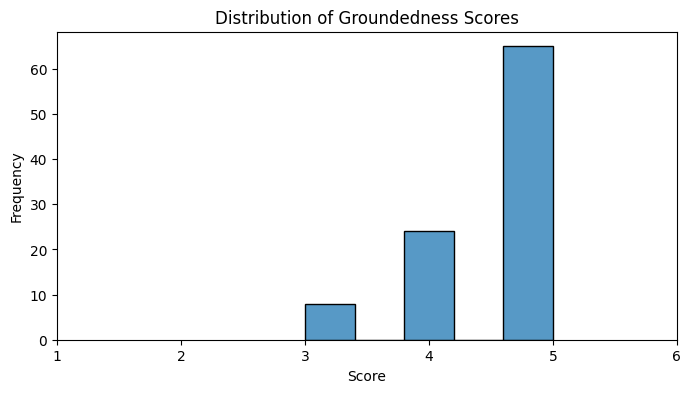

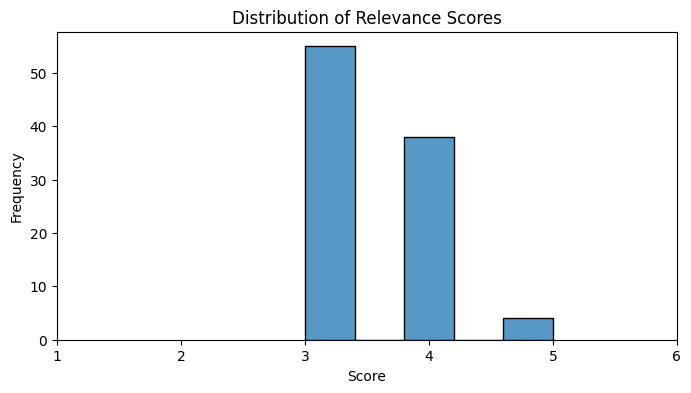

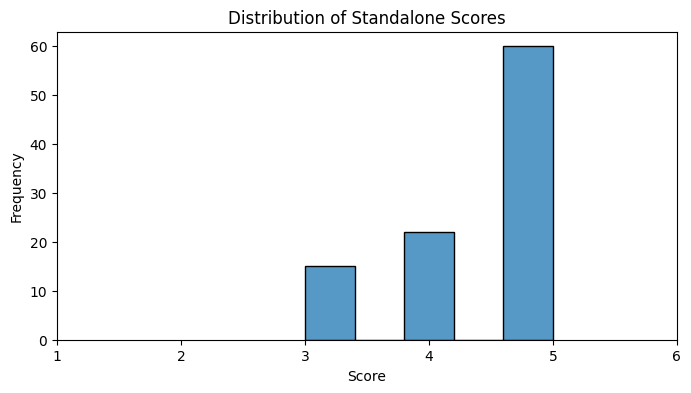

In [ ]:
def plot_evaluation_distribution(df, score_field, title):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[score_field], bins=5, kde=False)
    plt.title(title)
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.xticks(range(1, 7))
    plt.show()

plot_evaluation_distribution(generated_questions_cleaned_media_llama, "groundedness_score", "Distribution of Groundedness Scores")
plot_evaluation_distribution(generated_questions_cleaned_media_llama, "relevance_score", "Distribution of Relevance Scores")
plot_evaluation_distribution(generated_questions_cleaned_media_llama, "standalone_score", "Distribution of Standalone Scores")


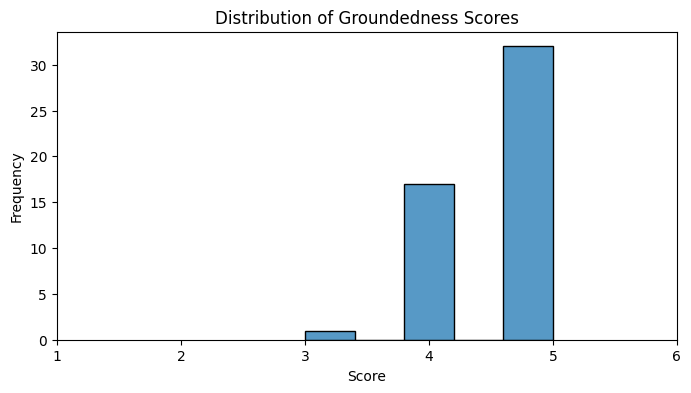

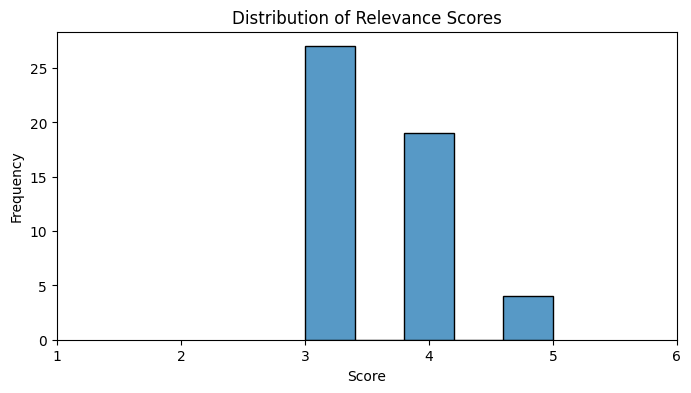

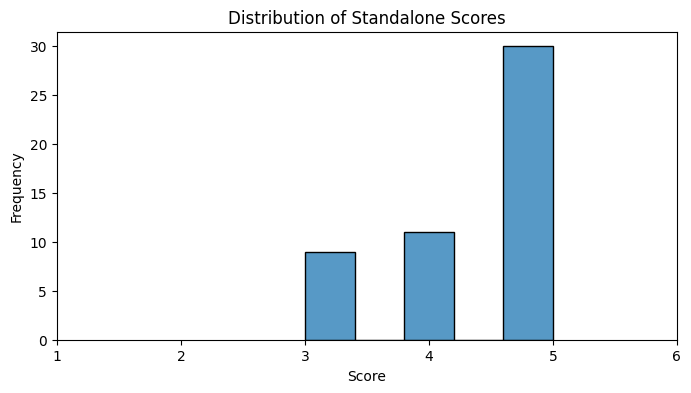

In [ ]:
plot_evaluation_distribution(generated_questions_cleaned_patent_llama, "groundedness_score", "Distribution of Groundedness Scores")
plot_evaluation_distribution(generated_questions_cleaned_patent_llama, "relevance_score", "Distribution of Relevance Scores")
plot_evaluation_distribution(generated_questions_cleaned_patent_llama, "standalone_score", "Distribution of Standalone Scores")

### Evaluation of the Human Evaluation Dataset Analysis

In addition to our generated QA pairs, we evalutate the human evaluation dataset(cleantech_rag_evaluation_data_2024-09-20.csv). This dataset is a small, high-quality evaluation set designed to benchmark the retrieval step in the RAG system. The human evaluators have already curated these 28 examples for quality.

We pass this dataset through our classification and evaluation pipeline to see how well our automated QA evaluation compares. After running the examples through the pipeline (which includes our LLM-based critique agents and filtering logic), we found that only 2 out of the 28 examples were classified as good.

This outcome highlights a few key insights:

  - High Standards for Quality:
  Our pipeline uses strict evaluation metrics for groundedness, relevance, and standalone clarity. The fact that only 2 examples met our threshold indicates that these metrics are effective at distinguishing high quality QA pairs from those that are ambiguous, irrelevant, or overly context dependent.

  - Differences in Human vs. Automated Judgment:
  Although the human evaluation dataset is curated for quality, our automated critique agents may apply slightly different standards. This gap can arise due to the inherent differences between human judgment and the deterministic nature of our LLM-based scoring.

  - Potential Areas for Improvement:
  The low pass rate (2/28) suggests that even the high-quality human-curated examples can sometimes fall short of our strict automatic evaluation criteria. This may be due to subtle issues in the questions or context that our models pick up on. It also indicates that our QA generation and evaluation techniques could be further fine-tuned to align better with human judgments.

  - Implications for the Retrieval Step:
  Since this evaluation dataset is specifically for assessing the Retrieval component of our RAG system, maintaining a high-quality benchmark is crucial. Even though our automated pipeline filters aggressively, ensuring that the retrieval component consistently returns the top-quality examples is a key factor in the overall system performance.

In summary, processing the human evaluation dataset demonstrates the robustness of our filtering and quality control process, while also revealing areas where our automated system might differ from human expectations. This insight is valuable for tuning both our QA generation methods and our evaluation criteria to create an optimal RAG system.


In [ ]:
human_eval.head()

,example_id,question_id,question,relevant_text,answer,article_url
0,1,1,What is the innovation behind LeclanchÃ©'s new method to produce lithium-ion batteries?,"LeclanchÃ© said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) batteries. It has replaced highly toxic organic solvents, commonly used in the production process, with a water-based process to make nickel-manganese-cobalt-aluminium cathodes (NMCA).",LeclanchÃ©'s innovation is using a water-based process instead of highly toxic organic solvents to produce nickel-manganese-cobalt-aluminium cathodes for lithium-ion batteries.,https://www.sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energy-density/
1,2,2,What is the EUâs Green Deal Industrial Plan?,"The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive and to accelerate its transition to net zero. It intends to support the expansion of European manufacturing of technologies, goods and services needed to achieve its climate targets.","The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry and accelerate the transition to net zero by supporting the expansion of European manufacturing of technologies, goods, and services necessary to meet climate targets.",https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/
2,3,2,What is the EUâs Green Deal Industrial Plan?,"The European counterpart to the US Inflation Reduction Act (IRA) aims to create an environment that is conducive to increasing the European Union's manufacturing capacity of ânet-zeroâ technologies, to improve the competitiveness of European industry.","The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry and accelerate the transition to net zero by supporting the expansion of European manufacturing of technologies, goods, and services necessary to meet climate targets.",https://www.pv-magazine.com/2023/02/02/european-commission-introduces-green-deal-industrial-plan/
3,4,3,What are the four focus areas of the EU's Green Deal Industrial Plan?,"The new plan is fundamentally focused on four areas, or pillars: the regulatory environment, access to finance, enhancing skills, and improving supply chain resilience. It also builds on other initiatives, such as REPowerEU, as well as the strength of the single market.","The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, access to finance, enhancing skills, and improving supply chain resilience.",https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/
4,5,4,When did the cooperation between GM and Honda on fuel cell vehicles start?,"What caught our eye was a new hookup between GM and Honda. Honda was also hammering away at the challenge of introducing fuel cell vehicles to the US market. The collaboration launched in July of 2013, providing for the two companies to share the combined total of 1,200 fuel cell patents they compiled in the years leading up to 2012.",July 2013,https://cleantechnica.com/2023/05/08/general-motors-seizes-the-fuel-cell-moment-with-green-hydrogen/


In [ ]:
# human_eval = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/human_eval_csv.csv")

In [ ]:

dfs = [human_eval]

human_eval_categorized_sentence_bert = stack_and_categorize(dfs,categories)

In [ ]:
human_eval_categorized_sentence_bert.head()

,example_id,question_id,question,relevant_text,answer,article_url,category
0,1,1,What is the innovation behind LeclanchÃ©'s new method to produce lithium-ion batteries?,"LeclanchÃ© said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) batteries. It has replaced highly toxic organic solvents, commonly used in the production process, with a water-based process to make nickel-manganese-cobalt-aluminium cathodes (NMCA).",LeclanchÃ©'s innovation is using a water-based process instead of highly toxic organic solvents to produce nickel-manganese-cobalt-aluminium cathodes for lithium-ion batteries.,https://www.sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energy-density/,Factual Questions
1,2,2,What is the EUâs Green Deal Industrial Plan?,"The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive and to accelerate its transition to net zero. It intends to support the expansion of European manufacturing of technologies, goods and services needed to achieve its climate targets.","The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry and accelerate the transition to net zero by supporting the expansion of European manufacturing of technologies, goods, and services necessary to meet climate targets.",https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/,Factual Questions
2,3,2,What is the EUâs Green Deal Industrial Plan?,"The European counterpart to the US Inflation Reduction Act (IRA) aims to create an environment that is conducive to increasing the European Union's manufacturing capacity of ânet-zeroâ technologies, to improve the competitiveness of European industry.","The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry and accelerate the transition to net zero by supporting the expansion of European manufacturing of technologies, goods, and services necessary to meet climate targets.",https://www.pv-magazine.com/2023/02/02/european-commission-introduces-green-deal-industrial-plan/,Factual Questions
3,4,3,What are the four focus areas of the EU's Green Deal Industrial Plan?,"The new plan is fundamentally focused on four areas, or pillars: the regulatory environment, access to finance, enhancing skills, and improving supply chain resilience. It also builds on other initiatives, such as REPowerEU, as well as the strength of the single market.","The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, access to finance, enhancing skills, and improving supply chain resilience.",https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/,Factual Questions
4,5,4,When did the cooperation between GM and Honda on fuel cell vehicles start?,"What caught our eye was a new hookup between GM and Honda. Honda was also hammering away at the challenge of introducing fuel cell vehicles to the US market. The collaboration launched in July of 2013, providing for the two companies to share the combined total of 1,200 fuel cell patents they compiled in the years leading up to 2012.",July 2013,https://cleantechnica.com/2023/05/08/general-motors-seizes-the-fuel-cell-moment-with-green-hydrogen/,Factual Questions


In [ ]:
outputs_human_eval = generate_output_list(human_eval_categorized_sentence_bert,name= 'human_eval')

In [ ]:
results_human_eval = create_eval(outputs_human_eval)

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
results_human_eval.to_csv("/content/drive/MyDrive/SwissText SharedTask/results_human_eval.csv")
#TODO: replace path with github link

In [ ]:
evaluated_results = eval_qa_pairs(results_human_eval)

Evaluation dataset before filtering:


,question,answer,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,What is the innovation behind LeclanchÃ©'s new method to produce lithium-ion batteries?,LeclanchÃ©'s innovation is using a water-based process instead of highly toxic organic solvents to produce nickel-manganese-cobalt-aluminium cathodes for lithium-ion batteries.,3,"The evaluation does not provide a clear understanding of the innovation, as the context only mentions the replacement of toxic solvents with a water-based process, without explaining how this change affects the production or performance of the lithium-ion batteries.",1,"The question asks about a specific innovation related to lithium-ion batteries, which is a technical topic. However, the question is about Leclanché, a company, and its new method, which suggests that the question may be more focused on the company's achievements rather than a general topic in NLP. The connection to NLP is not apparent, making the question less relevant to the topic. Additionally, the question is about a specific innovation, not a general question about NLP or Hugging Face ecosystem.",1,"The question implies that the reader is familiar with Leclanché, a company, and its products, specifically lithium-ion batteries. The question also assumes that the reader is aware of the context of innovation in battery production. Without additional information about Leclanché's specific new method, the question may seem vague or unclear to someone unfamiliar with the company or its products."
1,What is the EUâs Green Deal Industrial Plan?,"The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry and accelerate the transition to net zero by supporting the expansion of European manufacturing of technologies, goods, and services necessary to meet climate targets.",5,"The context provides sufficient information about the purpose and objectives of the EU's Green Deal Industrial Plan, allowing for a clear understanding of what the plan is intended to achieve. The language used is straightforward and accessible, and the description of the plan's goals is concise and specific.",2,"The given question appears to be a factual query about a specific policy initiative by the European Union. It is a straightforward and brief question that can be answered with a simple definition or explanation. However, in the context of machine learning development, especially with the Hugging Face ecosystem, the question might not be directly relevant unless the developers are specifically working on projects related to EU policy or environmental sustainability.",1,"The question explicitly mentions ""the EU's"" which indicates a reference to the European Union and its context, suggesting that the question depends on additional information to be understood in that specific context."
2,What is the EUâs Green Deal Industrial Plan?,"The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry and accelerate the transition to net zero by supporting the expansion of European manufacturing of technologies, goods, and services necessary to meet climate targets.",4,"Based on the given context, it is clear that the question is related to the EU's environmental and industrial policies, specifically the EU's efforts to promote sustainable growth and competitiveness. Furthermore, the mention of the US Inflation Reduction Act (IRA) suggests that the EU's Green Deal Industrial Plan is a policy initiative aimed at promoting clean energy and reducing carbon emissions. However, the exact details and content of the plan are not explicitly stated in the context.",2,"The question seems to be relatively vague and does not directly relate to NLP or the Hugging Face ecosystem, which focuses on natural language processing. However, the EU's Green Deal Industrial Plan could be relevant to developers working on sustainability and environmental impact

Final evaluation dataset:


,question,answer,groundedness_score,relevance_score,standalone_score
11,Why are milder winters detrimental for grapes and apples?,"Milder winters are detrimental for grapes and apples because these perennial species rely on consistent winter conditions for proper dormancy and bud timing, and erratic temperature swings disrupt these processes, making it difficult for growers to manage.",4,3,4
17,What is Agrivoltaics?,the integration of food production and solar energy to make better use of limited land and soil resources,4,4,5
18,What is Agrivoltaics?,the integration of food production and solar energy to make better use of limited land and soil resources,5,4,5
20,What are the obstacles for cannabis producers when it comes to using solar energy?,"limited access to financial instruments, inability to secure standard loans or mortgages, lack of access to tax-credit programs due to federal illegality, and increased investor risk since companies can't restructure through bankruptcy",4,3,5


In [ ]:
len(evaluated_results)

4

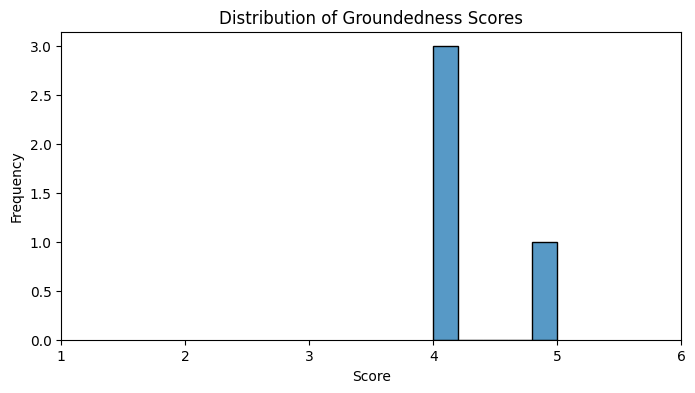

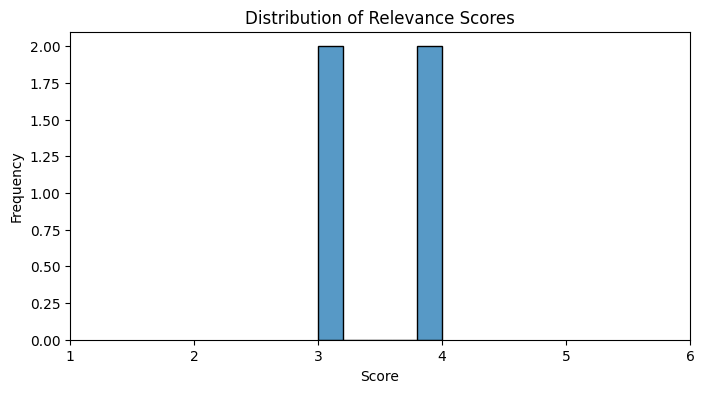

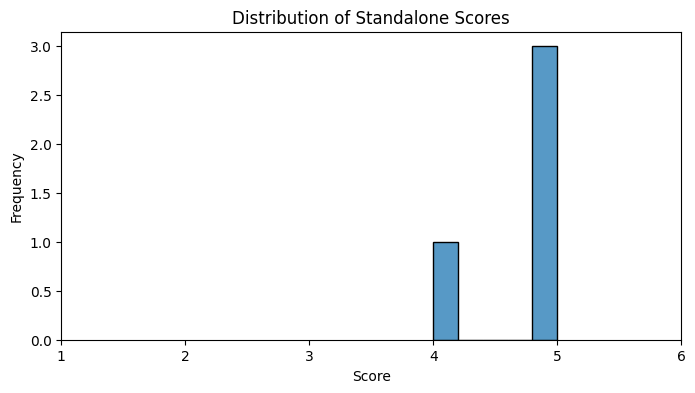

In [ ]:
plot_evaluation_distribution(evaluated_results, "groundedness_score", "Distribution of Groundedness Scores")
plot_evaluation_distribution(evaluated_results, "relevance_score", "Distribution of Relevance Scores")
plot_evaluation_distribution(evaluated_results, "standalone_score", "Distribution of Standalone Scores")

## 8. Conclusion & Next Steps

In this notebook, we explored the process of creating and analyzing QA pairs from 50–100 carefully selected paragraphs from the Cleantech Media and Google Patent datasets. By generating, classifying, and rigorously evaluating these QA pairs using LLMs, we built a high-quality dataset that serves as a robust foundation for our RAG pipeline.

Next Steps:

  - Integrate the filtered QA dataset into the implemeted RAG system.

  - Experiment with different LLM prompts and filtering thresholds to refine your QA pair quality.

  - Use the insights gained from the evaluation visualizations to further tune your retrieval and generation processes.